# Accelerating Cleantech Advancements through NLP-Powered Text Mining and Knowledge Extraction

Group: Marusa Storman, Vignesh Govindaraj, Pradip Ravichandran
## Stage 1: Enhanced Data Cleaning, Preprocessing, and Exploratory Analysis
### Data Collection

In [3]:
import pandas as pd
import string
import re
import nltk
import spacy
import json

In [167]:
#READ ALL FILES

# Read the JSON file
results_json = pd.read_json("bq-results-20240124-055833-1706076079048.json", lines=True)

# Read the first CSV file
ct_media = pd.read_csv("cleantech_media_dataset_v2_2024-02-23.csv")

# Read the second CSV file
ct_evaluation = pd.read_csv("cleantech_rag_evaluation_data_2024-02-23.csv")


In [228]:
# Display the first few rows of the DataFrame
print("First few rows:")
print(results_json.head())


First few rows:
  publication_number application_number country_code publication_date  \
0   US-2022239235-A1  US-202217717397-A           US       2022-07-28   
1   US-2022239235-A1  US-202217717397-A           US       2022-07-28   
2   US-2022239235-A1  US-202217717397-A           US       2022-07-28   
3   US-2022239235-A1  US-202217717397-A           US       2022-07-28   
4   US-2022239235-A1  US-202217717397-A           US       2022-07-28   

  inventor                               title_localized_text  \
0     None  adaptable dcac inverter drive system and opera...   
1     None  adaptable dcac inverter drive system and opera...   
2     None  adaptable dcac inverter drive system and opera...   
3     None  adaptable dcac inverter drive system and opera...   
4     None  adaptable dcac inverter drive system and opera...   

  title_localized_language                            abstract_localized_text  \
0                       en  disclosed is an adaptable dcac inverter syste

In [169]:
# This function replaces the describe() and info(). It will provide with more usefull information:

def analyze_column(df, head=True, has_list=False):
    if head:
        print(df.head())
        print()

    info = pd.DataFrame({
        'Data Type': df.dtypes,
        'Number of Entries': df.count(),
        'Missing/None Count': df.isna().sum()
    })
    
    if not has_list:
        info['Uniqueness'] = df.nunique()
   
    print(info)

analyze_column(results_json, has_list=True)

  publication_number application_number country_code  \
0   US-2022239235-A1  US-202217717397-A           US   
1   US-2022239251-A1  US-202217580956-A           US   
2      EP-4033090-A1      EP-21152924-A           EP   
3      EP-4033090-A1      EP-21152924-A           EP   
4     US-11396827-B2  US-202117606042-A           US   

                                     title_localized  \
0  [{'text': 'Adaptable DC-AC Inverter Drive Syst...   
1  [{'text': 'System for providing the energy fro...   
2  [{'text': 'Verfahren zum steuern einer windene...   
3  [{'text': 'Verfahren zum steuern einer windene...   
4  [{'text': 'Control method for optimizing solar...   

                                  abstract_localized  publication_date  \
0  [{'text': 'Disclosed is an adaptable DC-AC inv...          20220728   
1  [{'text': 'In accordance with an example embod...          20220728   
2  [{'text': 'Verfahren zum Steuern einer Windene...          20220727   
3  [{'text': 'Verfahren zum St

In [170]:
#### First time code was wrong, text was just preprocessed but stil embedded. This code split the embedded text
def flat_data(df, column_name):
    flattened_dicts = []
    
    for index, row in df.iterrows():
        specific_column = row.get(column_name, [])  # Get the list of title_localized values
    
        # Check if specific_column is not empty
        if specific_column:
            # Iterate through each title_localized value
            for specific_column_value in specific_column:
                # Check if the value is a dictionary
                if isinstance(specific_column_value, dict):
                    # Flatten the title_localized JSON object
                    flattened_row = {f"{column_name}_{key}": value for key, value in specific_column_value.items() if value}
    
                    # Append the modified row to flattened_dicts
                    flattened_dicts.append({**row, **flattened_row})
        else:
            # Append the original row if title_localized is empty
            flattened_dicts.append(row)
    
    # Create a new DataFrame from flattened_dicts
    flatten_df = pd.DataFrame(flattened_dicts)
    flatten_df.drop(columns=[column_name], inplace=True)
    return flatten_df

results_json = flat_data(results_json, 'title_localized')
results_json = flat_data(results_json, 'abstract_localized')
results_json = flat_data(results_json, 'cpc')

analyze_column(results_json, has_list=True)

  publication_number application_number country_code  publication_date  \
0   US-2022239235-A1  US-202217717397-A           US          20220728   
1   US-2022239235-A1  US-202217717397-A           US          20220728   
2   US-2022239235-A1  US-202217717397-A           US          20220728   
3   US-2022239235-A1  US-202217717397-A           US          20220728   
4   US-2022239235-A1  US-202217717397-A           US          20220728   

  inventor                               title_localized_text  \
0       []  Adaptable DC-AC Inverter Drive System and Oper...   
1       []  Adaptable DC-AC Inverter Drive System and Oper...   
2       []  Adaptable DC-AC Inverter Drive System and Oper...   
3       []  Adaptable DC-AC Inverter Drive System and Oper...   
4       []  Adaptable DC-AC Inverter Drive System and Oper...   

  title_localized_language                            abstract_localized_text  \
0                       en  Disclosed is an adaptable DC-AC inverter syste...   
1 

In [113]:
# Display summary statistics for numerical columns
#print("\nSummary statistics:")
#print(results_json.describe())

In [225]:
print("First few rows:")
print(ct_media.head())

First few rows:
   Unnamed: 0                                              title        date  \
0        1280  Qatar to Slash Emissions as LNG Expansion Adva...  2021-01-13   
1        1281               India Launches Its First 700 MW PHWR  2021-01-15   
2        1283              New Chapter for US-China Energy Trade  2021-01-20   
3        1284  Japan: Slow Restarts Cast Doubt on 2030 Energy...  2021-01-22   
4        1285     NYC Pension Funds to Divest Fossil Fuel Shares  2021-01-25   

  author                                            content       domain  \
0    NaN  ["Qatar Petroleum ( QP) is targeting aggressiv...  energyintel   
1    NaN  ["• Nuclear Power Corp. of India Ltd. ( NPCIL)...  energyintel   
2    NaN  ["New US President Joe Biden took office this ...  energyintel   
3    NaN  ["The slow pace of Japanese reactor restarts c...  energyintel   
4    NaN  ["Two of New York City's largest pension funds...  energyintel   

                                              

In [226]:
print("First few rows:")
print(ct_evaluation.head())

First few rows:
   example_id  question_id                                           question  \
0           1            1  What is the innovation behind Leclanché's new ...   
1           2            2       What is the EU’s Green Deal Industrial Plan?   
2           3            2       What is the EU’s Green Deal Industrial Plan?   
3           4            3  What are the four focus areas of the EU's Gree...   
4           5            4  When did the cooperation between GM and Honda ...   

                                      relevant_chunk  \
0  Leclanché said it has developed an environment...   
1  The Green Deal Industrial Plan is a bid by the...   
2  The European counterpart to the US Inflation R...   
3  The new plan is fundamentally focused on four ...   
4  What caught our eye was a new hookup between G...   

                                         article_url  
0  https://www.sgvoice.net/strategy/technology/23...  
1  https://www.sgvoice.net/policy/25396/eu-seeks-.

### JSON text preprocessing and EDA

In [171]:
results_json.head
# Based on the output, we have to change the date into readable form, preprocess publication and application number(not sure about that?), preprocess title and abstract text, address the missing in inventor and drop the cpc column (for now)

<bound method NDFrame.head of        publication_number application_number country_code  publication_date  \
0        US-2022239235-A1  US-202217717397-A           US          20220728   
1        US-2022239235-A1  US-202217717397-A           US          20220728   
2        US-2022239235-A1  US-202217717397-A           US          20220728   
3        US-2022239235-A1  US-202217717397-A           US          20220728   
4        US-2022239235-A1  US-202217717397-A           US          20220728   
...                   ...                ...          ...               ...   
489477     CN-113682495-A  CN-202110997949-A           CN          20211123   
489478     CN-113682495-A  CN-202110997949-A           CN          20211123   
489479     CN-113682495-A  CN-202110997949-A           CN          20211123   
489480     CN-113682495-A  CN-202110997949-A           CN          20211123   
489481     CN-113682495-A  CN-202110997949-A           CN          20211123   

                     

#### Change date format

In [172]:
# Change JSON date format
results_json['publication_date'] = pd.to_datetime(results_json['publication_date'], format='%Y%m%d')

#### Check and drop duplicates

In [173]:
# Calculate the total number of rows in the DataFrame
total_rows = len(results_json)

# Calculate the number of duplicate rows, excluding 'inventor'
columns_to_check = [col for col in results_json.columns if col != 'inventor']
duplicate_rows = results_json.duplicated(subset=columns_to_check, keep='first').sum()

# Calculate the percentage of duplicate rows
percentage_duplicates = (duplicate_rows / total_rows) * 100

print(f"Percentage of duplicate rows: {percentage_duplicates:.2f}%")
#68.2% of duplicate rows!!!

Percentage of duplicate rows: 68.27%


In [174]:
# Display some duplicate rows to inspect them
duplicates_to_inspect = results_json[results_json.duplicated(subset=columns_to_check, keep=False)]
print(duplicates_to_inspect.head())
##everything expect cpc_code and cpc_first seems the same! We need to further inspect to analyze the differences and decide how to handle duplicated data

   publication_number application_number country_code publication_date  \
12      EP-4033090-A1      EP-21152924-A           EP       2022-07-27   
13      EP-4033090-A1      EP-21152924-A           EP       2022-07-27   
14      EP-4033090-A1      EP-21152924-A           EP       2022-07-27   
15      EP-4033090-A1      EP-21152924-A           EP       2022-07-27   
16      EP-4033090-A1      EP-21152924-A           EP       2022-07-27   

                                             inventor  \
12  [Schaper, Ulf, von Aswege, Enno, Gerke Funcke,...   
13  [Schaper, Ulf, von Aswege, Enno, Gerke Funcke,...   
14  [Schaper, Ulf, von Aswege, Enno, Gerke Funcke,...   
15  [Schaper, Ulf, von Aswege, Enno, Gerke Funcke,...   
16  [Schaper, Ulf, von Aswege, Enno, Gerke Funcke,...   

                             title_localized_text title_localized_language  \
12  Verfahren zum steuern einer windenergieanlage                       de   
13  Verfahren zum steuern einer windenergieanlage       

In [175]:
# Group by fields that should be identical if the entries are truly duplicates
grouped = results_json.groupby([
    'publication_number', 'application_number', 'country_code',
    'publication_date', 'title_localized_text', 'title_localized_language',
    'abstract_localized_text', 'abstract_localized_language'
])

# Analyze the variation within each group for 'cpc_code'
variation = grouped['cpc_code'].nunique()

# Display groups with more than one unique 'cpc_code' to inspect variations
print(variation[variation > 1])

publication_number  application_number  country_code  publication_date  title_localized_text                                                                                                  title_localized_language  abstract_localized_text                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [138]:
import pandas as pd

# Assuming results_json is your DataFrame
# Columns to group by, excluding 'cpc_code' and 'inventor'
group_columns = [col for col in results_json.columns if col not in ('cpc_code', 'inventor')]

# Group by these columns and aggregate 'cpc_code' to see unique entries
grouped = results_json.groupby(group_columns)['cpc_code'].agg(['unique', 'nunique']).reset_index()

# Sort the DataFrame based on the number of unique CPC codes to see the groups with the most variety
grouped_sorted = grouped.sort_values(by='nunique', ascending=False)

# Display the top entries with the most variety in 'cpc_code'
print(grouped_sorted.head(10))


     publication_number application_number country_code publication_date  \
790      CN-110945234-B  CN-201980002226-A           CN       2021-12-14   
791      CN-110945234-B  CN-201980002226-A           CN       2021-12-14   
788      CN-110945234-B  CN-201980002226-A           CN       2021-12-14   
789      CN-110945234-B  CN-201980002226-A           CN       2021-12-14   
4623     CN-113719426-A  CN-202110566708-A           CN       2021-11-30   
4622     CN-113719426-A  CN-202110566708-A           CN       2021-11-30   
4621     CN-113719426-A  CN-202110566708-A           CN       2021-11-30   
4620     CN-113719426-A  CN-202110566708-A           CN       2021-11-30   
9325     CN-114057781-A  CN-202110871098-A           CN       2022-02-18   
176      CN-106902876-B  CN-201710129107-A           CN       2022-04-15   

                                   title_localized_text  \
790                                             海上能源岛装置   
791                                          

In [139]:
import pandas as pd

# Assuming results_json is your DataFrame
# Define columns that represent the text data and their translations
text_columns = ['title_localized_text', 'abstract_localized_text', 'title_localized_language', 'abstract_localized_language']

# Group by these text columns and aggregate 'cpc_code' to see unique entries
grouped = results_json.groupby(text_columns)['cpc_code'].agg(['unique', 'nunique']).reset_index()

# Add a new column to see how many different CPC codes there are per group
grouped['cpc_code_count'] = grouped['unique'].apply(len)

# Sort the DataFrame by the number of unique CPC codes to highlight entries with the most variation
grouped_sorted = grouped.sort_values(by='cpc_code_count', ascending=False)

# Display the top entries with the most CPC code variations
print(grouped_sorted.head(10))
#there are entries with very similar or identical text descriptions across different languages, and they're associated 
#with a large number of unique cpc_code values (45 in this case). This could suggest that despite the textual content 
#being translated and appearing the same across different languages, the classifications (as represented by cpc_code) are 
#highly varied.

                              title_localized_text  \
22111             Solar powered display assemblies   
22659           Solarbetriebene anzeigeanordnungen   
6658   Ensembles d&#39;affichage à énergie solaire   
6657   Ensembles d&#39;affichage à énergie solaire   
22658           Solarbetriebene anzeigeanordnungen   
22117            Solar powered vehicle topper unit   
22116            Solar powered vehicle topper unit   
22115        Solar powered vehicle mounted display   
22114        Solar powered vehicle mounted display   
22112             Solar powered display assemblies   

                                 abstract_localized_text  \
22111  La présente invention concerne des ensembles d...   
22659  Solar powered display assemblies and systems a...   
6658   Solar powered display assemblies and systems a...   
6657   La présente invention concerne des ensembles d...   
22658  La présente invention concerne des ensembles d...   
22117  A solar powered vehicle topper unit an

In [142]:
# Group by cpc_code to see related text entries and calculate aggregates
grouped_by_cpc = results_json.groupby('cpc_code').agg({
    'title_localized_text': lambda texts: set(texts),
    'abstract_localized_text': lambda texts: set(texts),
    'title_localized_language': lambda x: x.nunique(),  # Get number of unique languages for titles
    'abstract_localized_language': lambda x: x.nunique()  # Get number of unique languages for abstracts
}).reset_index()

# Add a column for counting occurrences of each cpc_code, already implicitly done by the size of the group
grouped_by_cpc['count'] = grouped_by_cpc['title_localized_text'].apply(len)

# Sort by the number of unique entries to see which CPC codes have the most variation
grouped_by_cpc_sorted = grouped_by_cpc.sort_values(by='count', ascending=False)
print(grouped_by_cpc_sorted.head())
## Dataframe with the CPC codes alongside corresponding sets of titles and abstracts in various languages, as 
#well as counts of how many entries are grouped under each CPC code

       cpc_code                               title_localized_text  \
6938  Y02E10/50  {Novel solar rolling shutter door, 一种模块化卫星电源, ...   
6951  Y02E10/72  {Multi-blade wind driven generator and using m...   
6982  Y02E70/30  {Novel solar rolling shutter door, Poröses sil...   
6937  Y02E10/47  {Secondary reflection system and solar light-g...   
6934  Y02E10/40  {Water-saving and energy-saving method by util...   

                                abstract_localized_text  \
6938  {本实用新型提供一种具有相变蓄热的太阳能热电联供装置，包括：水源高位水箱，设置有用于控制水源...   
6951  {本实用新型公开了一种环保节能的新型游艇，包括艇体和外护盒，艇体的后端设有外护盒，连接组件设...   
6982  {本发明提供一种混合储能系统，在该系统中，坡顶滑轨上的重物由绳子连接并穿过滑轮，然后将绳子缠...   
6937  {本实用新型属于太阳能技术领域，尤其涉及一种阳台太阳能利用装置，包括安装架和多块太阳能板，安...   
6934  {The application is a lithium bromide absorpti...   

      title_localized_language  abstract_localized_language  count  
6938                        12                           11   4855  
6951                        11                           10   1457  
6982             

In [176]:
### I guess we decided to drop the duplicates for now but we can always inspect and correct later if needed
# Columns to consider when checking for duplicates
columns_to_check = [col for col in results_json.columns if col != 'inventor']

# Find duplicate rows, except for the 'inventor' column
duplicates = results_json.duplicated(subset=columns_to_check, keep='first')

# Count the duplicates
duplicate_count = duplicates.sum()
print(f"Number of duplicate rows (excluding 'inventor'): {duplicate_count}")

# Drop the duplicates if needed
if duplicate_count > 0:
    results_json = results_json[~duplicates].reset_index(drop=True)


Number of duplicate rows (excluding 'inventor'): 334190


In [178]:
 results_json.duplicated(subset=[col for col in results_json.columns if col != 'inventor']).sum()
# extra code to make sure both calculate the same amount of duplicates 334190, and 0 after dropping

0

In [160]:
## Language detection in dataset
results_json.abstract_localized_language.unique()


array(['en', 'de', 'zh', 'ko', 'fr', 'ru', 'es', 'ro', 'lv', 'pl', 'ar',
       'sr', 'ja', 'hr', 'fi', 'el', 'pt', 'lt'], dtype=object)

#### Drop "cpc" columns

In [179]:
# Drop the 'cpc' column
results_json.drop(['cpc_code'], axis=1, inplace=True)
results_json.drop(['cpc_inventive'], axis=1, inplace=True)
results_json.drop(['cpc_first'], axis=1, inplace=True)

In [ ]:
# drop all cpc if found unneccesary, comment out above code

In [180]:
# Verify the columns have been dropped by printing the DataFrame's head
results_json.head()

,publication_number,application_number,country_code,publication_date,inventor,title_localized_text,title_localized_language,abstract_localized_text,abstract_localized_language
0,US-2022239235-A1,US-202217717397-A,US,2022-07-28,[],Adaptable DC-AC Inverter Drive System and Oper...,en,Disclosed is an adaptable DC-AC inverter syste...,en
1,US-2022239235-A1,US-202217717397-A,US,2022-07-28,[],Adaptable DC-AC Inverter Drive System and Oper...,en,Disclosed is an adaptable DC-AC inverter syste...,en
2,US-2022239235-A1,US-202217717397-A,US,2022-07-28,[],Adaptable DC-AC Inverter Drive System and Oper...,en,Disclosed is an adaptable DC-AC inverter syste...,en
3,US-2022239235-A1,US-202217717397-A,US,2022-07-28,[],Adaptable DC-AC Inverter Drive System and Oper...,en,Disclosed is an adaptable DC-AC inverter syste...,en
4,US-2022239235-A1,US-202217717397-A,US,2022-07-28,[],Adaptable DC-AC Inverter Drive System and Oper...,en,Disclosed is an adaptable DC-AC inverter syste...,en


#### Inspect "inventor" column

In [181]:
# Calculate the percentage of non-empty entries in 'inventor'
non_empty_inventors = results_json['inventor'].apply(bool).mean() * 100
print(f"Percentage of non-empty 'inventor' entries: {non_empty_inventors}%")


Percentage of non-empty 'inventor' entries: 67.2900085001159%


In [182]:
# Standardize the names in the 'inventor' column and handle missing data
results_json['inventor'] = results_json['inventor'].apply(lambda x: [name.strip().title() for name in x] if x else None)

# Create a new column for the count of inventors
results_json['num_inventors'] = results_json['inventor'].apply(lambda x: len(x) if x else 0)

# Create a binary indicator for multiple inventors
results_json['multiple_inventors'] = results_json['num_inventors'].apply(lambda x: 1 if x > 1 else 0)

# Check the results
print(results_json[['inventor', 'num_inventors', 'multiple_inventors']].head())

# Analyze the distribution of the number of inventors
print("Distribution of number of inventors:")
print(results_json['num_inventors'].value_counts())

  inventor  num_inventors  multiple_inventors
0     None              0                   0
1     None              0                   0
2     None              0                   0
3     None              0                   0
4     None              0                   0
Distribution of number of inventors:
0     50796
1     33395
2     12578
3     12275
4     10936
5      9797
6      7691
7      5845
8      3573
10     1954
9      1836
11     1008
12      921
15      735
13      600
14      568
16      146
18      132
21      130
20      116
19       96
17       96
22       36
25       20
24        4
38        4
29        4
Name: num_inventors, dtype: int64


#### Process publication and application number columns - we decided to hold this step and comment it out, it seems to be unnecessary for now

In [149]:
# Check for null values in 'country_code', to see if I can safely remove codes integrated in publication adn application column
#null_country_codes = results_json['country_code'].isnull().sum()
#print(f"Number of null entries in 'country_code': {null_country_codes}")


Number of null entries in 'country_code': 0


In [19]:
import re

# Define a function to remove the prefix and suffix
#def remove_prefix_suffix(text):
    # Remove the country code prefix
    text = re.sub(r'^[A-Za-z]+-', '', text)
    # Remove any suffix that starts with a dash after the numeric sequence
    text = re.sub(r'-.+$', '', text)
    return text

# Apply the function to the publication and application number columns
#results_json['publication_number'] = results_json['publication_number'].apply(remove_prefix_suffix)
#results_json['application_number'] = results_json['application_number'].apply(remove_prefix_suffix)

# Display the DataFrame to confirm the changes
#print(results_json[['publication_number', 'application_number']].head())

  publication_number application_number
0         2022239235       202217717397
1         2022239251       202217580956
2            4033090           21152924
3            4033090           21152924
4           11396827       202117606042


### Text cleaning 

In [165]:
import pandas as pd

# Check for null values in specific columns (adjust column names as per your DataFrame)
print(results_json['abstract_localized_text'].isnull().sum())
print(results_json['title_localized_text'].isnull().sum())


0
0


In [183]:
def unique_characters(data, column_name):
    unique_chars = set()
    for item in data[column_name].dropna():
        unique_chars.update(item)
    return sorted(unique_chars)

# Get unique characters from both columns
abstract_unique_chars = unique_characters(results_json, 'abstract_localized_text')
title_unique_chars = unique_characters(results_json, 'title_localized_text')

print("Unique characters in abstracts:", abstract_unique_chars)
print("Unique characters in titles:", title_unique_chars)

Unique characters in abstracts: ['\n', ' ', '#', '%', '&', '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '\x92', '\xa0', '«', '\xad', '°', '±', '²', '·', '»', 'À', 'É', 'Î', 'Ö', '×', 'Ü', 'ß', 'à', 'á', 'â', 'ã', 'ä', 'ç', 'è', 'é', 'ê', 'ë', 'í', 'î', 'ï', 'ñ', 'ó', 'ô', 'ö', 'ù', 'ú', 'û', 'ü', 'ā', 'ă', 'ą', 'ć', 'č', 'đ', 'ē', 'ė', 'ę', 'ģ', 'ī', 'Į', 'į', 'ķ', 'ł', 'ń', 'ņ', 'œ', 'ś', 'ş', 'Š', 'š', 'ţ', 'ū', 'ų', 'ź', 'ż', 'ž', 'ΐ', 'Δ', 'Η', 'Ο', 'Σ', 'Τ', 'Φ', 'ά', 'έ', 'ή', 'ί', 'α', 'β', 'γ', 'δ', 'ε', 'ζ', 'η', 'θ', 'ι', 'κ', 'λ', 'μ', 'ν', 'ξ', 'ο', 'π', 'ρ', 'ς', 'σ', 'τ', 'υ', 'φ', 'χ', 'ψ', 'ω', 'ϊ', 'ό', '

In [158]:
import pandas as pd
import re

#def clean_text(text):
    if pd.isna(text):
        return ""
    # Convert to lower case
    text = text.lower()
    # Remove HTML entities
    text = re.sub(r'&[a-zA-Z]+;', '', text)
    # Remove unwanted characters, but preserve hyphens within words
    text = re.sub(r'[^a-z\s\.,;:\'"\(\)\[\]{}\u4e00-\u9fff-]', '', text)
    # Clean up any stray hyphens that do not form part of a hyphenated word
    text = re.sub(r'\b-\b', ' ', text)
     # Remove specific unwanted characters and all punctuation except for internal hyphens
    text = re.sub(r'[():;,\[\]{}]', '', text)  # Removes (), [], {}, :, ;, and commas
    # Clean up any stray hyphens that do not form part of a hyphenated word
    text = re.sub(r'\b-\b', ' ', text)
    # Remove multiple spaces and trim
    text = re.sub(r'\s+', ' ', text).strip()
    return text
    # Normalize Chinese and other special characters by removing excess punctuation while keeping these characters
    text = re.sub(r'[\s]+', ' ', text).strip()
    return text

# Apply cleaning function to both columns
results_json['abstract_localized_text'] = results_json['abstract_localized_text'].apply(clean_text)
results_json['title_localized_text'] = results_json['title_localized_text'].apply(clean_text)

# Print cleaned text for inspection
print(results_json[['abstract_localized_text', 'title_localized_text']].head())


                             abstract_localized_text  \
0  disclosed is an adaptable dc ac inverter syste...   
1  disclosed is an adaptable dc ac inverter syste...   
2  disclosed is an adaptable dc ac inverter syste...   
3  disclosed is an adaptable dc ac inverter syste...   
4  disclosed is an adaptable dc ac inverter syste...   

                                title_localized_text  
0  adaptable dc ac inverter drive system and oper...  
1  adaptable dc ac inverter drive system and oper...  
2  adaptable dc ac inverter drive system and oper...  
3  adaptable dc ac inverter drive system and oper...  
4  adaptable dc ac inverter drive system and oper...  


In [229]:
import pandas as pd
import re
import unidecode


def clean_text(text):
    # Normalize text to ASCII
    text = unidecode.unidecode(text) ##double check why different characters for languages get deleted with this code, it should not
    # Convert text to lowercase
    text = text.lower()
    # Retain alphanumeric characters including those from provided languages, spaces, and select punctuation
    text = re.sub(r'[^\w\s\u4e00-\u9fff\u3400-\u4dbf\uf900-\ufaff\U00020000-\U0002a6df\U0002a700-\U0002ebef\U00030000-\U0003134f\U00031350-\U000323af\u3040-\u309F\u30A0-\u30FF\uAC00-\uD7AF\u0400-\u04FF\u0100-\u024F\u1E00-\u1EFF\u0370-\u03FF\u1F00-\u1FFF\u2C80-\u2CFF\u0100-\u017F\u0400-\u04FF]',
            '', text)
    return text


# Apply cleaning function to both columns
results_json['abstract_localized_text'] = results_json['abstract_localized_text'].apply(clean_text)
results_json['title_localized_text'] = results_json['title_localized_text'].apply(clean_text)

# Print cleaned text for inspection
print(results_json[['abstract_localized_text', 'title_localized_text']].head())


                             abstract_localized_text  \
0  disclosed is an adaptable dcac inverter system...   
1  disclosed is an adaptable dcac inverter system...   
2  disclosed is an adaptable dcac inverter system...   
3  disclosed is an adaptable dcac inverter system...   
4  disclosed is an adaptable dcac inverter system...   

                                title_localized_text  
0  adaptable dcac inverter drive system and opera...  
1  adaptable dcac inverter drive system and opera...  
2  adaptable dcac inverter drive system and opera...  
3  adaptable dcac inverter drive system and opera...  
4  adaptable dcac inverter drive system and opera...  


In [230]:
##inspect special characters again 
def get_unique_characters(df, column_name):
    unique_chars = set()
    for text in df[column_name]:
        unique_chars.update(text)
    return unique_chars

# Get unique characters from the cleaned abstract and title text
unique_chars_abstract = get_unique_characters(results_json, 'abstract_localized_text')
unique_chars_title = get_unique_characters(results_json, 'title_localized_text')

print("Unique characters in abstracts:", sorted(unique_chars_abstract))
print("Unique characters in titles:", sorted(unique_chars_title))


Unique characters in abstracts: ['\n', ' ', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Unique characters in titles: [' ', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [186]:
#
print(results_json.head(10))

  publication_number application_number country_code publication_date  \
0   US-2022239235-A1  US-202217717397-A           US       2022-07-28   
1   US-2022239235-A1  US-202217717397-A           US       2022-07-28   
2   US-2022239235-A1  US-202217717397-A           US       2022-07-28   
3   US-2022239235-A1  US-202217717397-A           US       2022-07-28   
4   US-2022239235-A1  US-202217717397-A           US       2022-07-28   
5   US-2022239235-A1  US-202217717397-A           US       2022-07-28   
6   US-2022239235-A1  US-202217717397-A           US       2022-07-28   
7   US-2022239235-A1  US-202217717397-A           US       2022-07-28   
8   US-2022239251-A1  US-202217580956-A           US       2022-07-28   
9   US-2022239251-A1  US-202217580956-A           US       2022-07-28   

  inventor                               title_localized_text  \
0     None  adaptable dcac inverter drive system and opera...   
1     None  adaptable dcac inverter drive system and opera...   
2

In [190]:
import nltk
from nltk.tokenize import word_tokenize

# You might need to ensure NLTK's resources are available
nltk.download('punkt')

# Tokenizing text
results_json['abstract_tokens'] = results_json['abstract_localized_text'].apply(word_tokenize)
results_json['title_tokens'] = results_json['title_localized_text'].apply(word_tokenize)

# Counting tokens
results_json['abstract_token_count'] = results_json['abstract_tokens'].apply(len)
results_json['title_token_count'] = results_json['title_tokens'].apply(len)

# Print to verify
print("Token counts in abstracts and titles:")
print(results_json[['abstract_localized_text', 'abstract_token_count', 'title_localized_text', 'title_token_count']].head())


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\maaru\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Token counts in abstracts and titles:
                             abstract_localized_text  abstract_token_count  \
0  disclosed is an adaptable dcac inverter system...                    64   
1  disclosed is an adaptable dcac inverter system...                    64   
2  disclosed is an adaptable dcac inverter system...                    64   
3  disclosed is an adaptable dcac inverter system...                    64   
4  disclosed is an adaptable dcac inverter system...                    64   

                                title_localized_text  title_token_count  
0  adaptable dcac inverter drive system and opera...                  7  
1  adaptable dcac inverter drive system and opera...                  7  
2  adaptable dcac inverter drive system and opera...                  7  
3  adaptable dcac inverter drive system and opera...                  7  
4  adaptable dcac inverter drive system and opera...                  7  


In [191]:
# Determine minimum and maximum token counts across the dataset
min_abstract_tokens = results_json['abstract_token_count'].min()
max_abstract_tokens = results_json['abstract_token_count'].max()
min_title_tokens = results_json['title_token_count'].min()
max_title_tokens = results_json['title_token_count'].max()

print("\nMinimum and maximum token counts:")
print(f"Abstracts - Min: {min_abstract_tokens}, Max: {max_abstract_tokens}")
print(f"Titles - Min: {min_title_tokens}, Max: {max_title_tokens}")


Minimum and maximum token counts:
Abstracts - Min: 1, Max: 486
Titles - Min: 1, Max: 36


#### Handle nonsensical and empty abstract and title text

In [196]:
# Set a threshold for minimum token count
min_token_threshold = 4 # Adjust as needed

# Filter English language entries
english_entries = results_json[(results_json['title_localized_language'] == 'en') & 
                               (results_json['abstract_localized_language'] == 'en')]

# Filter entries in the DataFrame with token count lower than the threshold within the English entries
low_abstract_token_entries = english_entries[english_entries['abstract_token_count'] < min_token_threshold]
low_title_token_entries = english_entries[english_entries['title_token_count'] < min_token_threshold]

# Examine the suspicious entries
print("Entries with low abstract token count:")
print(low_abstract_token_entries[['abstract_localized_text', 'abstract_token_count']])

print("\nEntries with low title token count:")
print(low_title_token_entries[['title_localized_text', 'title_token_count']])

# Based on examination, you can then decide to remove or correct the entries
# For example, to remove entries with low abstract token count from the original DataFrame:
#results_json = results_json[results_json['abstract_token_count'] >= min_token_threshold]

# Do the same for the title text if necessary
#results_json = results_json[results_json['title_token_count'] >= min_token_threshold]

# Based on examination, you can then decide to remove or correct the entries
# To remove entries with low abstract token count from the English entries
english_entries = english_entries[english_entries['abstract_token_count'] >= min_token_threshold]

# Do the same for the title text if necessary
english_entries = english_entries[english_entries['title_token_count'] >= min_token_threshold]

# Optionally, you might want to merge these filtered English entries back into the main DataFrame if needed
# This would replace the English entries in the main DataFrame with the filtered ones
results_json.update(english_entries)


Entries with low abstract token count:
Empty DataFrame
Columns: [abstract_localized_text, abstract_token_count]
Index: []

Entries with low title token count:
Empty DataFrame
Columns: [title_localized_text, title_token_count]
Index: []


In [199]:
# Print random samples from the English entries to inspect the data
print(english_entries[['abstract_localized_text', 'abstract_token_count', 'title_localized_text', 'title_token_count']].sample(5))


                                  abstract_localized_text  \
2463    the invention discloses an automatic identific...   
91216   the invention relates to the field of solar en...   
52453   the invention relates to a heatsupply rockgrou...   
128269  a solar powered vehicle topper unit and system...   
128463  the utility model relates to a dock multipoten...   

        abstract_token_count  \
2463                     143   
91216                    196   
52453                    260   
128269                   100   
128463                   160   

                                     title_localized_text  title_token_count  
2463    pasturing area livestock water supply system b...                 10  
91216   molten salt type solar thermal power generatio...                 12  
52453   rock heat supply rockground heat exchange devi...                 10  
128269                  solar powered vehicle topper unit                  5  
128463              wharf multienergy power s

In [197]:
 # Remove entries with zero tokens in abstract_text and title_text from results_json
results_json = results_json[(results_json['abstract_token_count'] > 0) & (results_json['title_token_count'] > 0)]

In [198]:
# Print the number of rows before filtering
print("Number of rows before filtering:", results_json.shape[0])

# Remove entries with zero tokens in abstract_text and title_text
filtered_results_json = results_json[(results_json['abstract_token_count'] > 0) & (results_json['title_token_count'] > 0)]

# Print the number of rows after filtering
print("Number of rows after filtering:", filtered_results_json.shape[0])

# Check the minimum token count in both columns
min_abstract_tokens = filtered_results_json['abstract_token_count'].min()
min_title_tokens = filtered_results_json['title_token_count'].min()

print("Minimum abstract token count:", min_abstract_tokens)
print("Minimum title token count:", min_title_tokens)


Number of rows before filtering: 48999
Number of rows after filtering: 48999
Minimum abstract token count: 4.0
Minimum title token count: 4.0


### Detect languages 

In [255]:
!pip install langdetect

     ---------------------------------------- 0.0/981.5 kB ? eta -:--:--
     ---- --------------------------------- 112.6/981.5 kB 3.3 MB/s eta 0:00:01
     ----------- -------------------------- 286.7/981.5 kB 3.0 MB/s eta 0:00:01
     ----------------------- -------------- 604.2/981.5 kB 4.2 MB/s eta 0:00:01
     -------------------------------------  972.8/981.5 kB 5.6 MB/s eta 0:00:01
     -------------------------------------- 981.5/981.5 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993253 sha256=b2cd51aab8d21c7b3580f512863f80f9cc702c9af941e201ae80dbcd84fe7089
  Stored in directory: c:\users\maaru\appdata\local\pip\cache\wheels\0a\f2\b2\e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect


In [33]:
from langdetect import detect
##old code

# Function to detect language
#def detect_language(text):
    try:
        return detect(text)
    except:
        return "error"  # Returns "error" if the language detection fails

# Apply language detection to abstracts and titles
results_json['abstract_language'] = results_json['abstract_text'].apply(detect_language)
results_json['title_language'] = results_json['title_text'].apply(detect_language)

# Print to verify
print(results_json[['abstract_text', 'abstract_language', 'title_text', 'title_language']].head(20))
#some abstract and title text are nonsensical and empty, so I will address this to be able to receive correct language detection

                                        abstract_text abstract_language  \
0   disclosed is an adaptable dc ac inverter syste...                en   
1   in accordance with an example embodiment a sol...                en   
2   verfahren zum steuern einer windenergieanlage ...                de   
3   verfahren zum steuern einer windenergieanlage ...                de   
4   a control method for optimizing a solar to pow...                en   
7   the invention relates to the technical field o...                en   
17  the invention discloses a wind power generatio...                en   
18  the application discloses a solar energy absor...                en   
25  the invention relates to the technical field o...                en   
30  a method for curing and protecting a side slop...                en   
33  the invention discloses a solar monitoring dev...                en   
36  the utility model discloses a water conservanc...                en   
39  the intelligent green

In [204]:
print(results_json.head(10))

  publication_number application_number country_code publication_date  \
0   US-2022239235-A1  US-202217717397-A           US       2022-07-28   
1   US-2022239235-A1  US-202217717397-A           US       2022-07-28   
2   US-2022239235-A1  US-202217717397-A           US       2022-07-28   
3   US-2022239235-A1  US-202217717397-A           US       2022-07-28   
4   US-2022239235-A1  US-202217717397-A           US       2022-07-28   
5   US-2022239235-A1  US-202217717397-A           US       2022-07-28   
6   US-2022239235-A1  US-202217717397-A           US       2022-07-28   
7   US-2022239235-A1  US-202217717397-A           US       2022-07-28   
8   US-2022239251-A1  US-202217580956-A           US       2022-07-28   
9   US-2022239251-A1  US-202217580956-A           US       2022-07-28   

  inventor                               title_localized_text  \
0     None  adaptable dcac inverter drive system and opera...   
1     None  adaptable dcac inverter drive system and opera...   
2

In [206]:
# Check the distribution of languages in both abstracts and titles
abstract_lang_distribution = results_json['abstract_localized_language'].value_counts()
title_lang_distribution = results_json['title_localized_language'].value_counts()

# Display the language distributions
print("Language distribution in abstracts:")
print(abstract_lang_distribution)
print("\nLanguage distribution in titles:")
print(title_lang_distribution)


Language distribution in abstracts:
en    42007
fr     3730
zh     1025
ko      866
de      823
ru      195
fi      102
ar       89
es       77
pt       24
ro       19
ja       16
lt       12
hr        4
el        4
pl        2
lv        2
sr        2
Name: abstract_localized_language, dtype: int64

Language distribution in titles:
en    42735
fr     3958
de     1214
ko      463
ru      257
ar       92
es       77
sv       68
fi       68
pt       24
ro       20
lt       12
el        4
lv        2
sr        2
hr        2
pl        1
Name: title_localized_language, dtype: int64


In [205]:
import pandas as pd

# Assuming your DataFrame is named 'results_json'
# Calculate the frequency of languages in each column
abstract_lang_distribution = results_json['abstract_localized_language'].value_counts()
title_lang_distribution = results_json['title_localized_language'].value_counts()

# Combine both distributions into a single DataFrame for easier comparison
language_distribution = pd.DataFrame({
    'Abstract Language Distribution': abstract_lang_distribution,
    'Title Language Distribution': title_lang_distribution
}).fillna(0)  # Fill NaN with 0 for languages that might not appear in both columns

# Print the combined language distribution
print(language_distribution)


    Abstract Language Distribution  Title Language Distribution
ar                            89.0                         92.0
de                           823.0                       1214.0
el                             4.0                          4.0
en                         42007.0                      42735.0
es                            77.0                         77.0
fi                           102.0                         68.0
fr                          3730.0                       3958.0
hr                             4.0                          2.0
ja                            16.0                          0.0
ko                           866.0                        463.0
lt                            12.0                         12.0
lv                             2.0                          2.0
pl                             2.0                          1.0
pt                            24.0                         24.0
ro                            19.0      

In [207]:
# Print in readable form, decide tomorrow what to do with this data? Some are nonsensical 

for index, row in less_common_abstracts.iterrows():
    print(f"Row {index}:")
    print(f"Publication Number: {row['publication_number']}")
    print(f"Application Number: {row['application_number']}")
    print(f"Country Code: {row['country_code']}")
    print(f"Publication Date: {row['publication_date']}")
    print(f"Inventor: {row['inventor']}")
    print(f"CPC Code: {row['cpc_code']}")
    print(f"CPC Inventive: {row['cpc_inventive']}")
    print(f"CPC First: {row['cpc_first']}")
    print(f"Number of Inventors: {row['num_inventors']}")
    print(f"Multiple Inventors: {row['multiple_inventors']}")
    print(f"Abstract Text: {row['abstract_text']}")
    print(f"Title Text: {row['title_text']}")
    print(f"Abstract Language: {row['abstract_language']}")
    print(f"Title Language: {row['title_language']}")
    print(f"Abstract Tokens: {row['abstract_tokens']}")
    print(f"Title Tokens: {row['title_tokens']}")
    print(f"Abstract Token Count: {row['abstract_token_count']}")
    print(f"Title Token Count: {row['title_token_count']}")
    print("\n")  # Add extra newline for readability


Row 156:
Publication Number: 114776441
Application Number: 202210451055
Country Code: CN
Publication Date: 2022-07-22 00:00:00
Inventor: None
CPC Code: None
CPC Inventive: None
CPC First: None
Number of Inventors: 0
Multiple Inventors: 0
Abstract Text: co co h oco co
Title Text: cocomprehensive energy system for co electrolysis combined oxygen enriched combustion power generation and co production method
Abstract Language: pt
Title Language: en
Abstract Tokens: ['co', 'co', 'h', 'oco', 'co']
Title Tokens: ['cocomprehensive', 'energy', 'system', 'for', 'co', 'electrolysis', 'combined', 'oxygen', 'enriched', 'combustion', 'power', 'generation', 'and', 'co', 'production', 'method']
Abstract Token Count: 5
Title Token Count: 16


Row 176:
Publication Number: 114776441
Application Number: 202210451055
Country Code: CN
Publication Date: 2022-07-22 00:00:00
Inventor: None
CPC Code: None
CPC Inventive: None
CPC First: None
Number of Inventors: 0
Multiple Inventors: 0
Abstract Text: co co h oco

In [209]:
#Inspect mismatching languages for abstract and title
mismatched_language_count = results_json[results_json['abstract_localized_language'] != results_json['title_localized_language']]
print(mismatched_language_count.head(20))

    publication_number application_number country_code publication_date  \
18       EP-4033090-A1      EP-21152924-A           EP       2022-07-27   
19       EP-4033090-A1      EP-21152924-A           EP       2022-07-27   
20       EP-4033090-A1      EP-21152924-A           EP       2022-07-27   
21       EP-4033090-A1      EP-21152924-A           EP       2022-07-27   
22       EP-4033090-A1      EP-21152924-A           EP       2022-07-27   
23       EP-4033090-A1      EP-21152924-A           EP       2022-07-27   
24       EP-4033090-A1      EP-21152924-A           EP       2022-07-27   
25       EP-4033090-A1      EP-21152924-A           EP       2022-07-27   
26       EP-4033090-A1      EP-21152924-A           EP       2022-07-27   
27       EP-4033090-A1      EP-21152924-A           EP       2022-07-27   
28       EP-4033090-A1      EP-21152924-A           EP       2022-07-27   
29       EP-4033090-A1      EP-21152924-A           EP       2022-07-27   
317     CN-114784861-A  C

In [210]:
mismatched_language_count = results_json[results_json['abstract_localized_language'] != results_json['title_localized_language']].shape[0]
print(f"Number of rows with mismatched languages: {mismatched_language_count}")

Number of rows with mismatched languages: 7308


In [277]:
### DO SPELLCHECKING --- DO NOT RUN YET, TAKES FOREVER

!pip install pyspellchecker

In [ ]:
##################3 Insanelly long running time, over 1 h, code below might be faster but I will work on other steps first
from spellchecker import SpellChecker

# Create spellchecker instances for each language
#spellcheckers = {
    'en': SpellChecker(language='en'),
    'de': SpellChecker(language='de'),
    'fr': SpellChecker(language='fr'),
    'it': SpellChecker(language='it')
}

# Function to correct spelling in a text based on its language
def correct_spelling(text, language):
    # Return text as is if it's None or not a string
    if text is None or not isinstance(text, str):
        return text

    if language not in spellcheckers:
        return text  # No spellchecking for unsupported languages

    spell = spellcheckers[language]
    words = text.split()
    # Ensure that the spell.correction is not None
    corrected_text = [spell.correction(word) if (word in spell.unknown(words) and spell.correction(word) is not None) else word for word in words]
    return ' '.join(corrected_text)


# Apply spellchecking to a DataFrame
for index, row in results_json.iterrows():
    if row['abstract_language'] in spellcheckers:
        results_json.at[index, 'abstract_text'] = correct_spelling(row['abstract_text'], row['abstract_language'])
    if row['title_language'] in spellcheckers:
        results_json.at[index, 'title_text'] = correct_spelling(row['title_text'], row['title_language'])


In [ ]:
### AGAIN LOOOONG running time, I will work on other steps and focus on spellchecker at the end
from collections import Counter
from spellchecker import SpellChecker

# Create spellchecker instances for each language
#spellcheckers = {
    'en': SpellChecker(language='en'),
    'de': SpellChecker(language='de'),
    'fr': SpellChecker(language='fr'),
    'it': SpellChecker(language='it')
}

# Gather all unique words in the abstracts and titles
all_words = Counter()
results_json['abstract_text'].str.split().apply(all_words.update)
results_json['title_text'].str.split().apply(all_words.update)

# Identify the misspelled words
misspelled = {}
for lang, spell in spellcheckers.items():
    # This filters the unique words by language and checks if they are misspelled
    unique_words = [word for word in all_words if word in spell.unknown(all_words.keys())]
    misspelled[lang] = {word: spell.correction(word) for word in unique_words}

# Function to replace misspelled words based on the earlier identified ones
def replace_misspelled(text, language):
    if language not in misspelled:
        return text
    return ' '.join([misspelled[language].get(word, word) for word in text.split()])

# Apply the correction function to the DataFrame
results_json['abstract_text'] = results_json.apply(lambda row: replace_misspelled(row['abstract_text'], row['abstract_language']), axis=1)
results_json['title_text'] = results_json.apply(lambda row: replace_misspelled(row['title_text'], row['title_language']), axis=1)

#### Co-occurances analysation

In [211]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Function to calculate co-occurrences
def calculate_cooccurrences(data, column):
    # Define a count vectorizer
    count_vectorizer = CountVectorizer(
        max_df=0.9,
        min_df=0.01,
        stop_words='english',
        binary=True
    )

    # Transform the text into binary flags
    counts = count_vectorizer.fit_transform(data[column])

    # Get the names of each column
    ngrams = count_vectorizer.get_feature_names_out()

    # Compute the product to get a co-occurrence matrix
    cooccurs = (counts.T * counts)

    # Fill the diagonal with zeros
    cooccurs.setdiag(0)

    # Convert to a dense format and make a DataFrame
    cooccurs_df = pd.DataFrame(cooccurs.todense(), index=ngrams, columns=ngrams)
    
    return cooccurs_df

# Calculate co-occurrences for the 'abstract_text' column
cooccurs_abstract = calculate_cooccurrences(results_json, 'abstract_localized_language')

# Calculate co-occurrences for the 'title_text' column
cooccurs_title = calculate_cooccurrences(results_json, 'title_localized_language')

# Display the co-occurrence DataFrames
print("Co-occurrences in abstracts:")
print(cooccurs_abstract.head())

print("\nCo-occurrences in titles:")
print(cooccurs_title.head())

Co-occurrences in abstracts:
    en  fr  ko  zh
en   0   0   0   0
fr   0   0   0   0
ko   0   0   0   0
zh   0   0   0   0

Co-occurrences in titles:
    en  fr
en   0   0
fr   0   0


#### Worldcloud

In [216]:
!pip install wordcloud

In [231]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

# Set preferences
sns.set(color_codes=True)

In [239]:
# WORLDCLOUD for abstract
#all_abstract = results_json['abstract_localized_language']

In [240]:
# Concatenate strings in the Series/Index with cat() function to have all reviews as a string.
#all_abstract.str.cat()

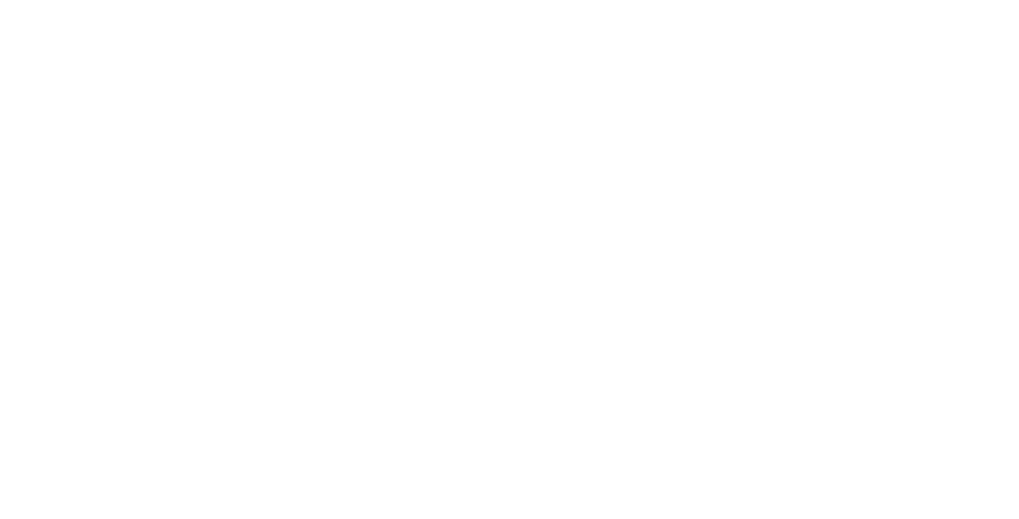

In [234]:
# Visualize
#wordcloud = WordCloud(width = 800, height = 400,
                background_color ='white',
                min_font_size = 5).generate(all_abstract.str.cat())

# plot the WordCloud image
#plt.figure(figsize = (10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

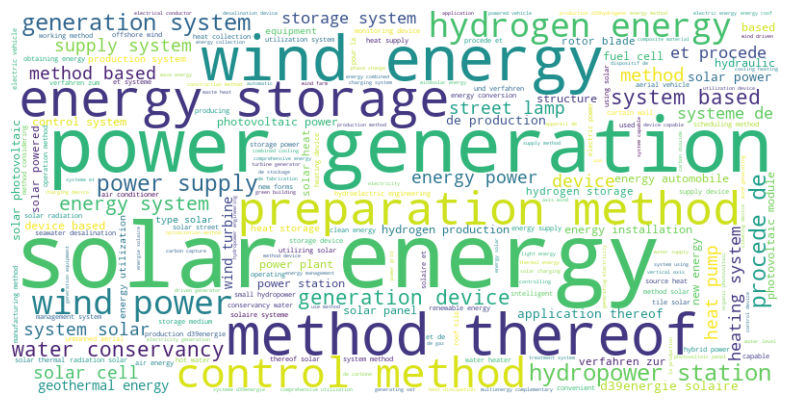

In [237]:
# WORLDCLOUD for title 
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Combine all abstracts into one large text
all_title = ' '.join(results_json['title_localized_text'].dropna())

# Create and generate a word cloud image
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_title)

# Display the generated image:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

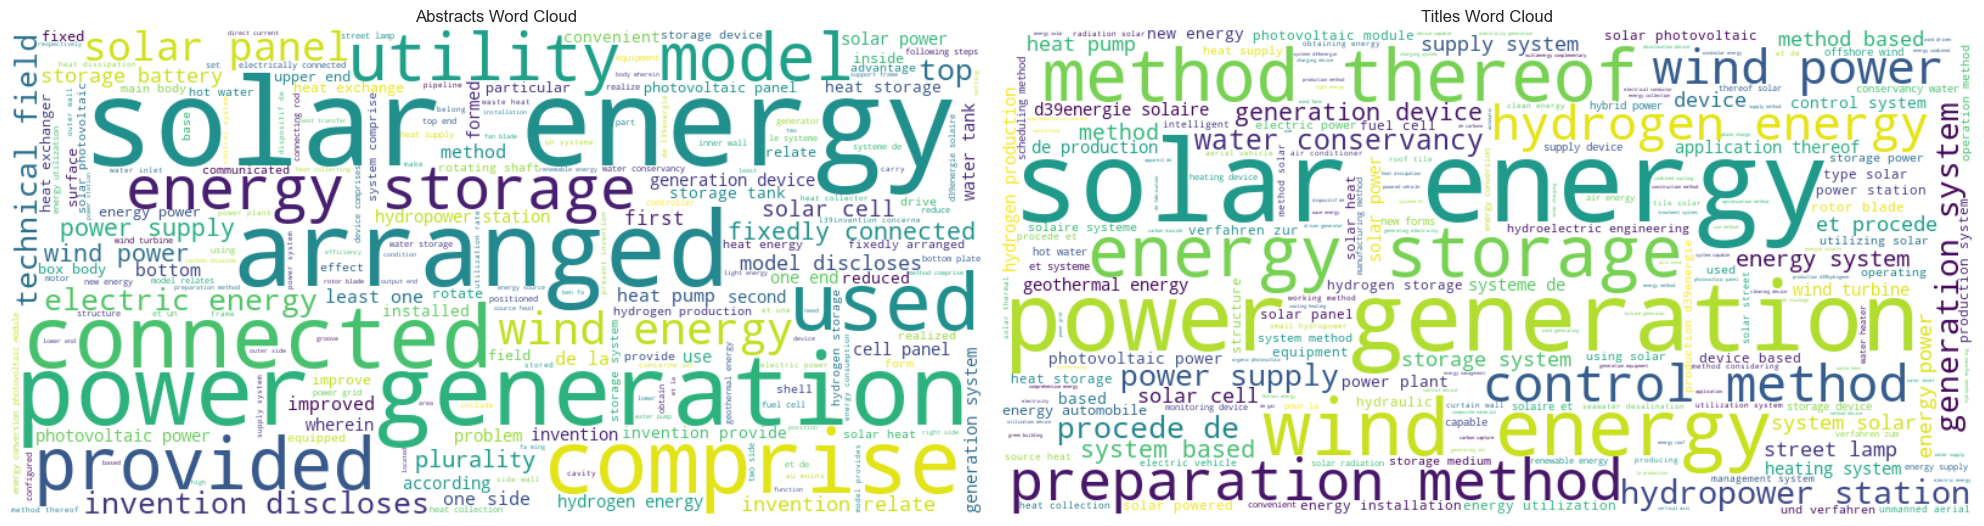

In [238]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd

# Assuming 'results_json' is your DataFrame and it's already loaded

# Combine texts from abstracts and titles into separate strings
abstract_text = ' '.join(results_json['abstract_localized_text'].tolist())
title_text = ' '.join(results_json['title_localized_text'].tolist())

# Create word cloud objects
abstract_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(abstract_text)
title_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(title_text)

# Setup matplotlib figures
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Display the word clouds
axes[0].imshow(abstract_wordcloud, interpolation='bilinear')
axes[0].set_title('Abstracts Word Cloud')
axes[0].axis('off')  # Hide the axes for abstract word cloud

axes[1].imshow(title_wordcloud, interpolation='bilinear')
axes[1].set_title('Titles Word Cloud')
axes[1].axis('off')  # Hide the axes for title word cloud

plt.tight_layout()
plt.show()


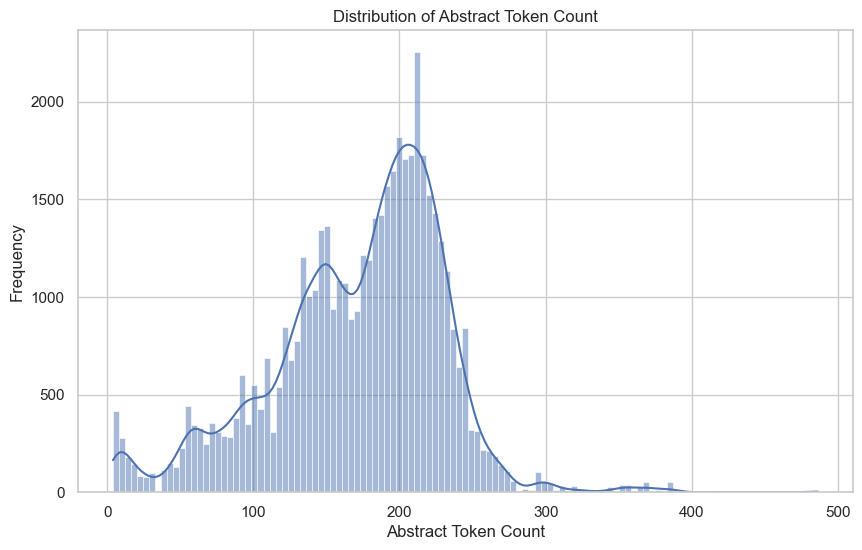

In [241]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Histogram for abstract token count
plt.figure(figsize=(10, 6))
sns.histplot(results_json['abstract_token_count'], kde=True)
plt.title('Distribution of Abstract Token Count')
plt.xlabel('Abstract Token Count')
plt.ylabel('Frequency')
plt.show()

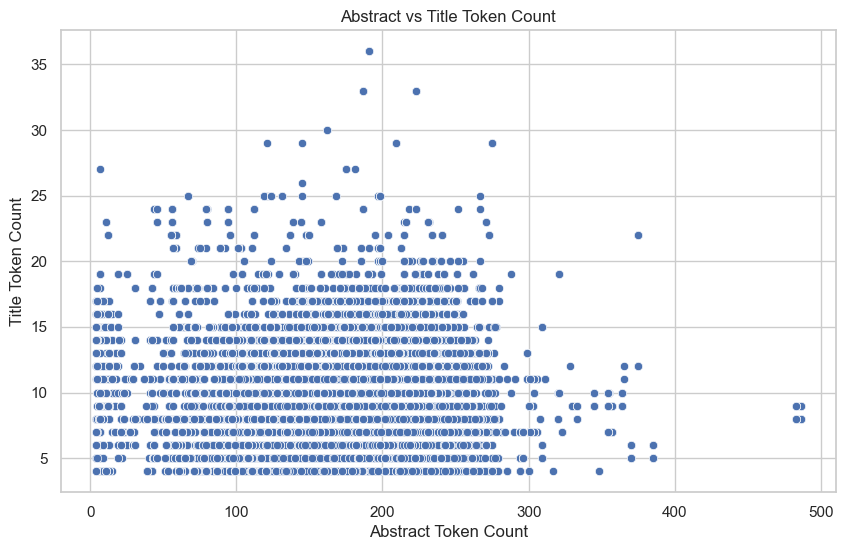

In [242]:
# Scatter plot for abstract vs title token count
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_json, x='abstract_token_count', y='title_token_count')
plt.title('Abstract vs Title Token Count')
plt.xlabel('Abstract Token Count')
plt.ylabel('Title Token Count')
plt.show()

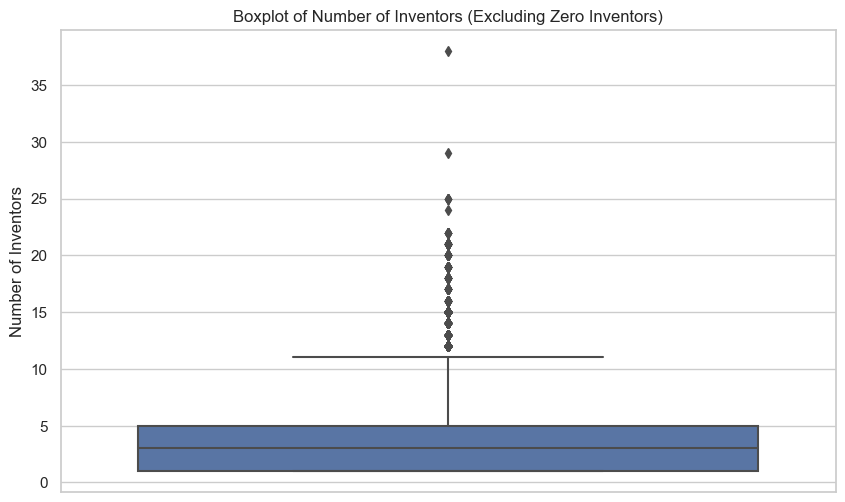

In [243]:
# Boxplot for number of inventors
# Exclude rows with zero inventors.
filtered_data = results_json[results_json['num_inventors'] > 0]

# Now, we can create a boxplot for the number of inventors.
plt.figure(figsize=(10, 6))
sns.boxplot(data=filtered_data, y='num_inventors')
plt.title('Boxplot of Number of Inventors (Excluding Zero Inventors)')
plt.ylabel('Number of Inventors')
plt.show()

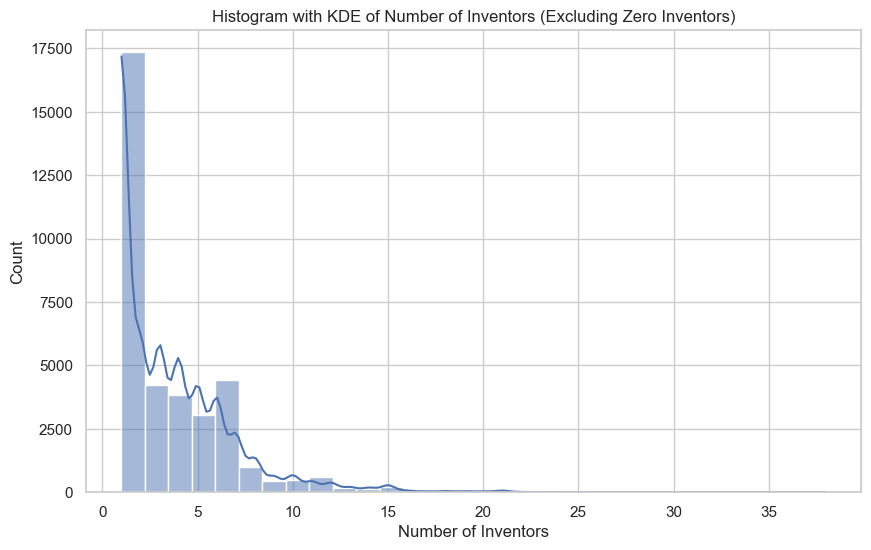

In [244]:
# Kernel Density Estimate (KDE) plot
plt.figure(figsize=(10, 6))
sns.histplot(filtered_data['num_inventors'], bins=30, kde=True)
plt.title('Histogram with KDE of Number of Inventors (Excluding Zero Inventors)')
plt.xlabel('Number of Inventors')
plt.ylabel('Count')
plt.show()

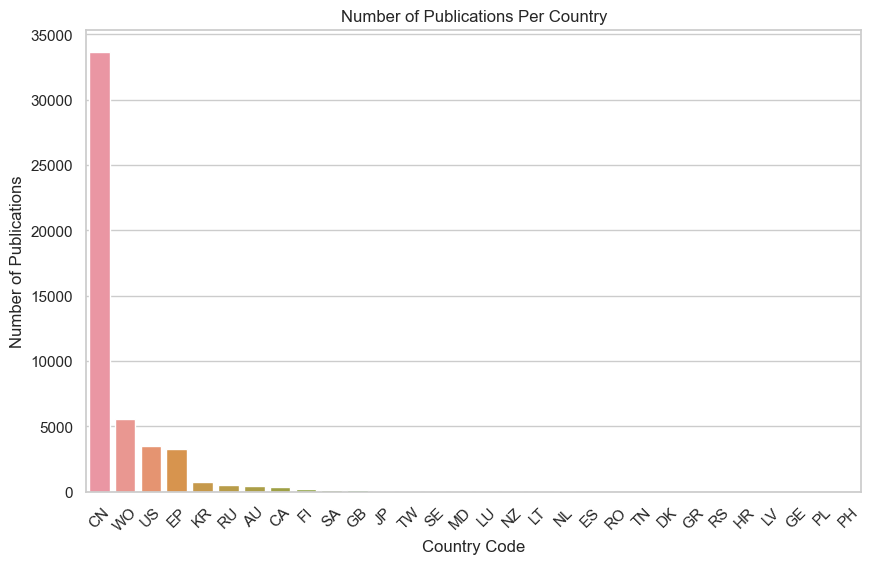

In [245]:
# Bar chart for publications per country
plt.figure(figsize=(10, 6))
sns.countplot(data=results_json, x='country_code', order=results_json['country_code'].value_counts().index)
plt.title('Number of Publications Per Country')
plt.xlabel('Country Code')
plt.ylabel('Number of Publications')
plt.xticks(rotation=45)
plt.show()

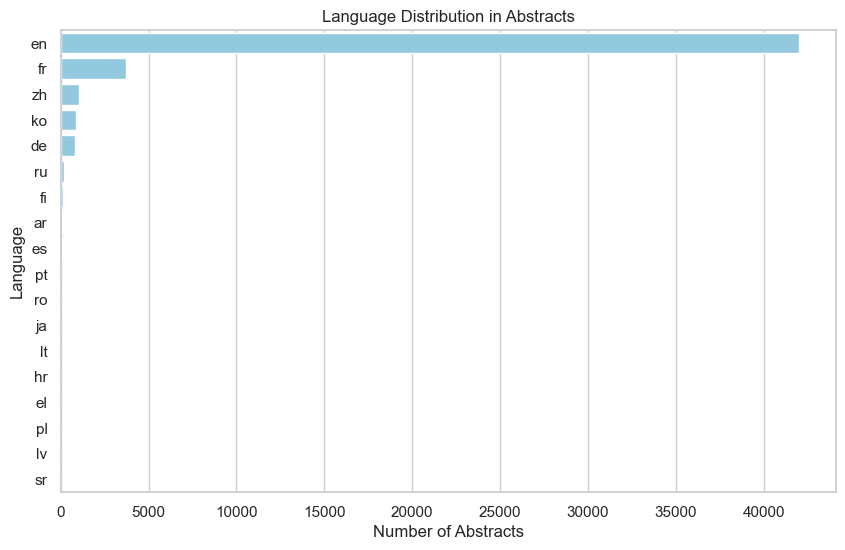

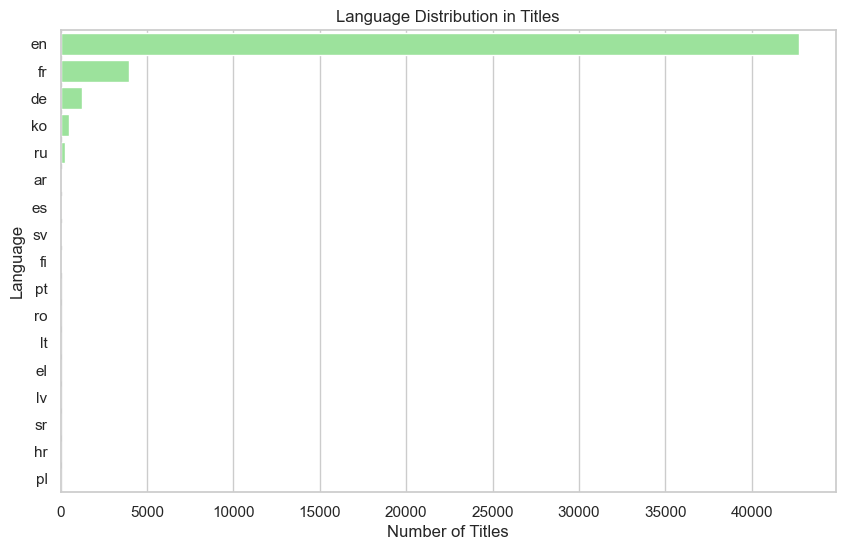

In [246]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Plot for language distribution in abstracts
plt.figure(figsize=(10, 6))
sns.barplot(x=abstract_lang_distribution.values, y=abstract_lang_distribution.index, color='skyblue')
plt.title('Language Distribution in Abstracts')
plt.xlabel('Number of Abstracts')
plt.ylabel('Language')
plt.show()

# Plot for language distribution in titles
plt.figure(figsize=(10, 6))
sns.barplot(x=title_lang_distribution.values, y=title_lang_distribution.index, color='lightgreen')
plt.title('Language Distribution in Titles')
plt.xlabel('Number of Titles')
plt.ylabel('Language')
plt.show()


#### UNIGRAMS 

#### Unigram with stopwords

In [247]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Function to get top n unigrams
def get_top_n_words(corpus, n=None, stopwords=None):
    vec = CountVectorizer(stop_words=stopwords).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

In [250]:
top_n_unigrams = get_top_n_words(results_json['abstract_localized_text'], n=20)
df_unigrams = pd.DataFrame(top_n_unigrams, columns=['word', 'count'])

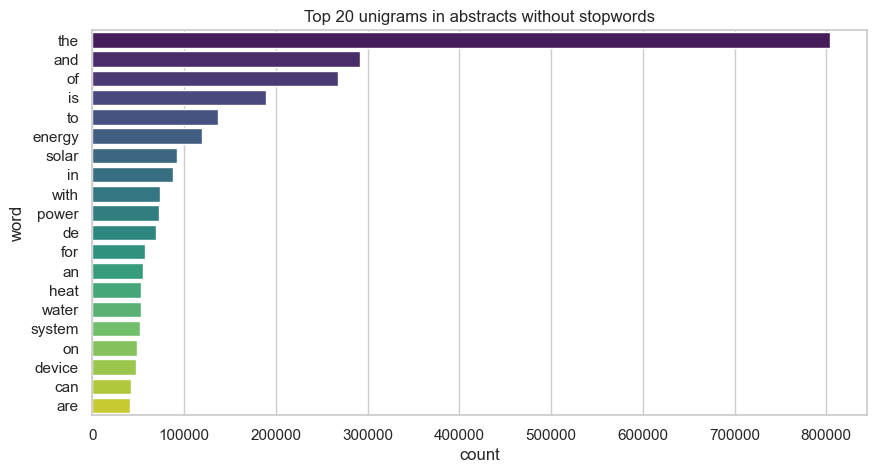

In [251]:
plt.figure(figsize=(10, 5))
sns.barplot(x='count', y='word', data=df_unigrams, palette='viridis')
plt.title('Top 20 unigrams in abstracts without stopwords')
plt.show()

#### Unigram without stopwords

In [252]:
top_n_unigrams_stop = get_top_n_words(results_json['abstract_localized_text'], n=20, stopwords='english')
df_unigrams_stop = pd.DataFrame(top_n_unigrams_stop, columns=['word', 'count'])

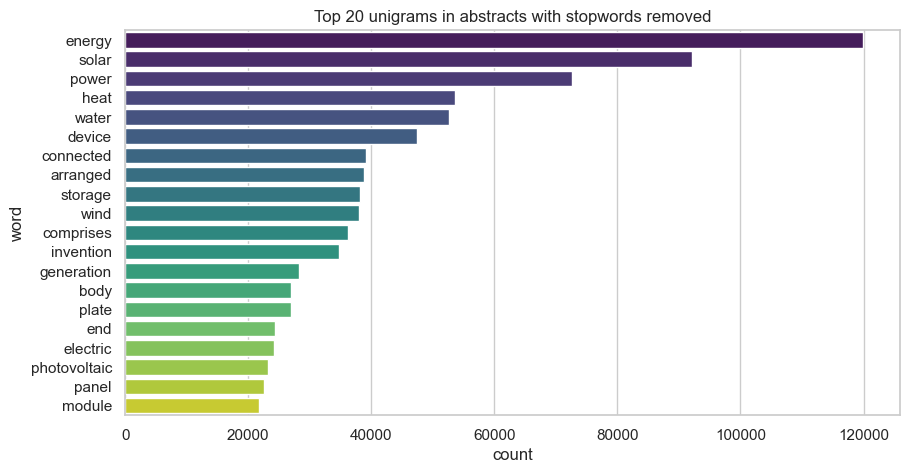

In [253]:
plt.figure(figsize=(10, 5))
sns.barplot(x='count', y='word', data=df_unigrams_stop, palette='viridis')
plt.title('Top 20 unigrams in abstracts with stopwords removed')
plt.show()

#### Bigrams 

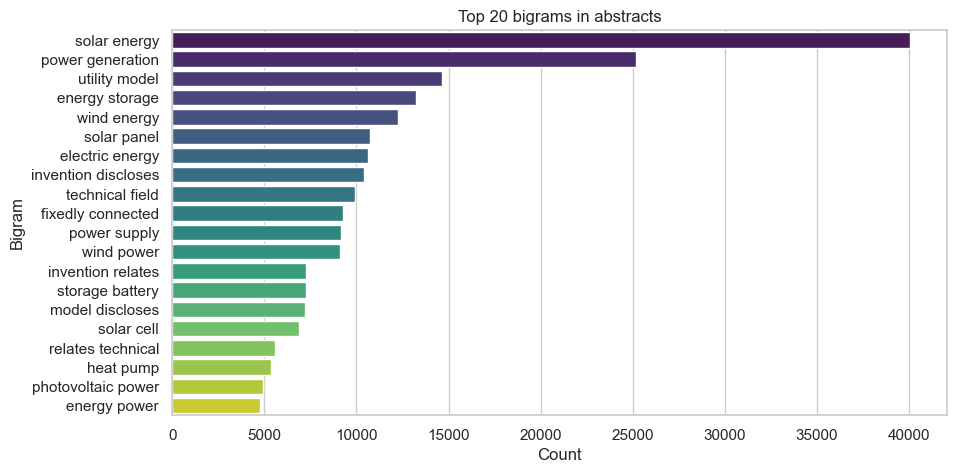

In [254]:
def get_top_n_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Assuming 'results_json' is your DataFrame and 'abstract_text' is the column with abstracts
# Get the top n bigrams from the abstracts
top_n_bigrams = get_top_n_bigrams(results_json['abstract_localized_text'], n=20)
df_bigrams = pd.DataFrame(top_n_bigrams, columns=['bigram', 'count'])

# Plot the top n bigrams
plt.figure(figsize=(10, 5))
sns.barplot(x='count', y='bigram', data=df_bigrams, palette='viridis')
plt.title('Top 20 bigrams in abstracts')
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.show()

#### Handle duplicates 


We decided to handle duplicates after convertion of columns (for easier process and to avoid overwriting the code).

In [255]:
# Convert list columns to strings to enable hashing
results_json['abstract_tokens_str'] = results_json['abstract_tokens'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
results_json['title_tokens_str'] = results_json['title_tokens'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

# Temporarily drop columns that may contain complex data types like lists or dicts
temp_df = results_json.drop(columns=['abstract_tokens', 'title_tokens', 'inventor'])

# Now check for duplicates in this temporary DataFrame
duplicates = temp_df.duplicated(subset=None, keep='first').sum()
print(f"Remaining duplicates: {duplicates}")

# If you want to remove duplicates, do so and then add back the dropped columns
#if duplicates > 0:
    #results_json = results_json.loc[~temp_df.duplicated(subset=None, keep='first')].reset_index(drop=True)

# You can drop duplicates if needed using the following line:
# results_json = results_json.drop_duplicates(subset=None, keep='first').reset_index(drop=True)


Remaining duplicates: 34910


In [59]:
# Identify duplicates
is_duplicate = temp_df.duplicated(subset=None, keep='first')
print(is_duplicate.head(10))

# Remove duplicates
results_json = results_json[~is_duplicate].reset_index(drop=True)

# Print the head of the DataFrame to inspect the first few rows
print(results_json.head())
#Mabye add this step before visualizations.

0     False
1     False
2     False
3      True
4     False
7     False
17    False
18    False
25    False
30    False
dtype: bool
  publication_number application_number country_code publication_date  \
0         2022239235       202217717397           US       2022-07-28   
1         2022239251       202217580956           US       2022-07-28   
2            4033090           21152924           EP       2022-07-27   
3           11396827       202117606042           US       2022-07-26   
4          114777546       202210702520           CN       2022-07-22   

                                            inventor    cpc_code  \
0                                               None  H02M7/5395   
1                                               None   H02S40/38   
2  [Schaper, Ulf, Von Aswege, Enno, Gerke Funcke,...  F03D7/0276   
3                                               None   F24S50/00   
4                                               None        None   

  cpc_inventive cpc_

## CSV PROCESSING

#### CT_Evaluation cleaning

In [81]:
#Look into data frame already uploaded at the beginning of the notebook

print("First few rows:")
print(ct_evaluation.head(24))


First few rows:
    example_id  question_id  \
0            1            1   
1            2            2   
2            3            2   
3            4            3   
4            5            4   
5            6            5   
6            7            6   
7            8            7   
8            9            8   
9           10            9   
10          11           10   
11          12           11   
12          13           12   
13          14           13   
14          15           14   
15          16           15   
16          17           16   
17          18           17   
18          19           17   
19          20           18   
20          21           19   
21          22           20   
22          23           21   

                                             question  \
0   what is the innovation behind leclanche's new ...   
1         what is the eus green deal industrial plan?   
2         what is the eus green deal industrial plan?   
3   what ar

In [68]:
print("\nData information:")
print(ct_evaluation.info())


Data information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   example_id      23 non-null     int64 
 1   question_id     23 non-null     int64 
 2   question        23 non-null     object
 3   relevant_chunk  23 non-null     object
 4   article_url     23 non-null     object
dtypes: int64(2), object(3)
memory usage: 1.0+ KB
None


In [69]:
# Check for missing values in each column
missing_data = ct_evaluation.isnull().sum()
print("Missing values in each column:")
print(missing_data)
# No missing data, which simplyify our cleaning steps

Missing values in each column:
example_id        0
question_id       0
question          0
relevant_chunk    0
article_url       0
dtype: int64


In [70]:
import pandas as pd

def generate_summary(df):
    # Identify non-hashable columns (e.g., columns with lists)
    non_hashable_columns = [col for col in df.columns if isinstance(df[col].dropna().iloc[0], list)]
    
    # Exclude non-hashable columns from the nunique calculation
    hashable_columns = df.drop(columns=non_hashable_columns)
    
    # Essentials: type, unique values, missing values
    summary = pd.DataFrame({
        'type': df.dtypes,
        'unique_values': hashable_columns.nunique(),
        'missing_values': df.isnull().sum()
    })
    
    # Quantile statistics for numeric columns only
    numeric_cols = df.select_dtypes(include='number')
    quantiles = numeric_cols.quantile([0, 0.25, 0.5, 0.75, 1]).transpose()
    
    # Add quantile stats to the summary
    summary_stats = pd.concat([summary, quantiles], axis=1, sort=False)
    
    # Compute range and interquartile range (IQR)
    if not numeric_cols.empty:  # Only calculate if there are numeric columns
        summary_stats['range'] = summary_stats[1.0] - summary_stats[0.0]
        summary_stats['iqr'] = summary_stats[0.75] - summary_stats[0.25]
    
    return summary_stats

# Apply the summary function to your datasets
ct_evaluation_summary = generate_summary(ct_evaluation)
# ct_media_summary = generate_summary(ct_media) # Uncomment when needed

# Display the summaries
print("Summary for ct_evaluation:")
print(ct_evaluation_summary)


Summary for ct_evaluation:
                  type  unique_values  missing_values  0.0  0.25   0.5  0.75  \
example_id       int64             23               0  1.0   6.5  12.0  17.5   
question_id      int64             21               0  1.0   5.5  11.0  16.5   
question        object             21               0  NaN   NaN   NaN   NaN   
relevant_chunk  object             23               0  NaN   NaN   NaN   NaN   
article_url     object             21               0  NaN   NaN   NaN   NaN   

                 1.0  range   iqr  
example_id      23.0   22.0  11.0  
question_id     21.0   20.0  11.0  
question         NaN    NaN   NaN  
relevant_chunk   NaN    NaN   NaN  
article_url      NaN    NaN   NaN  


In [77]:
# Look into unique characters to indentify which ones to remove
# Create sets to hold unique characters
unique_chars_question = set()
unique_chars_chunk = set()

# Update sets with characters from each row
for question, chunk in zip(ct_evaluation['question'], ct_evaluation['relevant_chunk']):
    unique_chars_question.update(question)
    unique_chars_chunk.update(chunk)

# Print the unique characters
print("Unique characters in 'question' column:")
print(sorted(unique_chars_question))
print("\nUnique characters in 'relevant_chunk' column:")
print(sorted(unique_chars_chunk))

Unique characters in 'question' column:
[' ', '"', "'", ',', '-', '0', '1', '2', '3', '5', '?', 'A', 'C', 'D', 'E', 'G', 'H', 'I', 'L', 'M', 'P', 'S', 'U', 'W', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'y', 'é', '’']

Unique characters in 'relevant_chunk' column:
[' ', '&', "'", '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5', '8', '9', ':', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Z', '[', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'é', '–', '’', '“', '”']


In [84]:
import unicodedata
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Initialize a lemmatizer
lemmatizer = WordNetLemmatizer()

def standardize_text(text):
    # Normalize and convert to lowercase
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8').lower()
    
    # Replace special apostrophes and quotation marks
    text = text.replace('’', "'").replace('“', '"').replace('”', '"')
    
    # Standardize dashes
    text = text.replace('–', '-')  # Replace en-dash with hyphen
    
    #remove links
    text = re.sub(r'<[^>]*>', ' ', text)
    
    # Remove punctuation and numbers
    text = re.sub(r'[\W_]+', ' ', text)  # \W_ matches any non-alphanumeric character underscore included
    
    
    return text
    

# Apply the cleaning function to both 'question' and 'relevant_chunk' columns
ct_evaluation['question'] = ct_evaluation['question'].apply(standardize_text)
ct_evaluation['relevant_chunk'] = ct_evaluation['relevant_chunk'].apply(standardize_text)

# Display the cleaned text to confirm changes
print("Standardized 'question' column:")
print(ct_evaluation['question'].head())
print("\nStandardized 'relevant_chunk' column:")
print(ct_evaluation['relevant_chunk'].head())
##Should we remove numbers as well?

Standardized 'question' column:
0    what is the innovation behind leclanche s new ...
1          what is the eus green deal industrial plan 
2          what is the eus green deal industrial plan 
3    what are the four focus areas of the eu s gree...
4    when did the cooperation between gm and honda ...
Name: question, dtype: object

Standardized 'relevant_chunk' column:
0    leclanche said it has developed an environment...
1    the green deal industrial plan is a bid by the...
2    the european counterpart to the us inflation r...
3    the new plan is fundamentally focused on four ...
4    what caught our eye was a new hookup between g...
Name: relevant_chunk, dtype: object


In [85]:
# Function to extract unique characters from text
def extract_unique_characters(text_series):
    unique_characters = set()
    for text in text_series:
        unique_characters.update(text)
    return sorted(unique_characters)

# Apply the function to cleaned 'question' and 'relevant_chunk' columns
unique_chars_in_question_cleaned = extract_unique_characters(ct_evaluation['question'])
unique_chars_in_chunk_cleaned = extract_unique_characters(ct_evaluation['relevant_chunk'])

# Display the unique characters
print("Unique characters in cleaned 'question' column:")
print(unique_chars_in_question_cleaned)
print("\nUnique characters in cleaned 'relevant_chunk' column:")
print(unique_chars_in_chunk_cleaned)
###needs more cleaning? ask chatgpt if numbers can be written in words

Unique characters in cleaned 'question' column:
[' ', '0', '1', '2', '3', '5', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'y', 'z']

Unique characters in cleaned 'relevant_chunk' column:
[' ', '0', '1', '2', '3', '4', '5', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [86]:
# Function to count tokens in text
def count_tokens(text):
    return len(text.split())

# Count tokens and create new columns
ct_evaluation['question_token_count'] = ct_evaluation['question'].apply(count_tokens)
ct_evaluation['relevant_chunk_token_count'] = ct_evaluation['relevant_chunk'].apply(count_tokens)

# Display the DataFrame to confirm changes
print("\nDataFrame with token counts:")
print(ct_evaluation[['question', 'question_token_count', 'relevant_chunk', 'relevant_chunk_token_count']].head())


DataFrame with token counts:
                                            question  question_token_count  \
0  what is the innovation behind leclanche s new ...                    14   
1        what is the eus green deal industrial plan                      8   
2        what is the eus green deal industrial plan                      8   
3  what are the four focus areas of the eu s gree...                    14   
4  when did the cooperation between gm and honda ...                    13   

                                      relevant_chunk  \
0  leclanche said it has developed an environment...   
1  the green deal industrial plan is a bid by the...   
2  the european counterpart to the us inflation r...   
3  the new plan is fundamentally focused on four ...   
4  what caught our eye was a new hookup between g...   

   relevant_chunk_token_count  
0                          42  
1                          47  
2                          37  
3                          42  
4   

#### URL cleaning

In [89]:
# Summary of the article_url column
url_summary = ct_evaluation['article_url'].agg(['dtype', 'nunique', 'count', pd.Series.nunique, pd.Series.unique])

# Check for missing values
url_summary['missing_values'] = ct_evaluation['article_url'].isnull().sum()

# Display the summary
print(url_summary)


dtype                                                        object
nunique                                                          21
count                                                            23
nunique                                                          21
unique            [https://www.sgvoice.net/strategy/technology/2...
missing_values                                                    0
Name: article_url, dtype: object


In [88]:
import pandas as pd
from urllib.parse import urlparse, urlunparse

def clean_url(url):
    # Parse the URL
    parsed_url = urlparse(url.lower())
    # Reconstruct without query and fragment
    cleaned_url = urlunparse((parsed_url.scheme, parsed_url.netloc, parsed_url.path, '', '', ''))
    return cleaned_url

def extract_domain(url):
    # Parse the URL and extract the domain
    domain = urlparse(url.lower()).netloc
    # Remove 'www.' if it exists
    domain = domain.replace('www.', '')
    # Extract only the main part of the domain before the first dot
    main_part = domain.split('.')[0]
    return main_part

# Apply cleaning to the article_url column
ct_evaluation['cleaned_article_url'] = ct_evaluation['article_url'].apply(clean_url)
ct_evaluation['domain'] = ct_evaluation['article_url'].apply(extract_domain)

# Display the cleaned URLs and domains
print(ct_evaluation[['article_url', 'cleaned_article_url', 'domain']])

                                          article_url  \
0   https://www.sgvoice.net/strategy/technology/23...   
1   https://www.sgvoice.net/policy/25396/eu-seeks-...   
2   https://www.pv-magazine.com/2023/02/02/europea...   
3   https://www.sgvoice.net/policy/25396/eu-seeks-...   
4   https://cleantechnica.com/2023/05/08/general-m...   
5   https://solarindustrymag.com/scout-and-colgate...   
6   https://cleantechnica.com/2023/01/02/the-wait-...   
7   https://cleantechnica.com/2023/05/15/what-does...   
8   https://cleantechnica.com/2023/05/15/mississip...   
9   https://cleantechnica.com/2023/05/18/solar-pan...   
10  https://www.azocleantech.com/news.aspx?newsID=...   
11  https://www.azocleantech.com/news.aspx?newsID=...   
12  https://www.azocleantech.com/news.aspx?newsID=...   
13  https://www.azocleantech.com/news.aspx?newsID=...   
14  https://www.azocleantech.com/news.aspx?newsID=...   
15  https://www.thinkgeoenergy.com/japan-and-icela...   
16  https://www.thinkgeoenergy.

In [90]:
# inspect again
print(ct_evaluation.head(24))

    example_id  question_id  \
0            1            1   
1            2            2   
2            3            2   
3            4            3   
4            5            4   
5            6            5   
6            7            6   
7            8            7   
8            9            8   
9           10            9   
10          11           10   
11          12           11   
12          13           12   
13          14           13   
14          15           14   
15          16           15   
16          17           16   
17          18           17   
18          19           17   
19          20           18   
20          21           19   
21          22           20   
22          23           21   

                                             question  \
0   what is the innovation behind leclanche s new ...   
1         what is the eus green deal industrial plan    
2         what is the eus green deal industrial plan    
3   what are the four focus

#### Remove stopwords

In [91]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

# Function to remove stopwords
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    return ' '.join([word for word in text.split() if word.lower() not in stop_words])

# Remove stopwords from 'question' and 'relevant_chunk'
ct_evaluation['question_clean'] = ct_evaluation['question'].apply(remove_stopwords)
ct_evaluation['relevant_chunk_clean'] = ct_evaluation['relevant_chunk'].apply(remove_stopwords)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maaru\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Co-occurrances analysation

In [101]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Function to calculate co-occurrences
def calculate_cooccurrences(data, column):
    # Define a count vectorizer
    count_vectorizer = CountVectorizer(
        max_df=0.9,
        min_df=0.01,
        stop_words='english',
        binary=True
    )

    # Transform the text into binary flags
    counts = count_vectorizer.fit_transform(data[column])

    # Get the names of each column
    ngrams = count_vectorizer.get_feature_names_out()

    # Compute the product to get a co-occurrence matrix
    cooccurs = (counts.T * counts)

    # Fill the diagonal with zeros
    cooccurs.setdiag(0)

    # Convert to a dense format and make a DataFrame
    cooccurs_df = pd.DataFrame(cooccurs.todense(), index=ngrams, columns=ngrams)
    
    return cooccurs_df

# Calculate co-occurrences for the 'abstract_text' column
cooccurs_question = calculate_cooccurrences(ct_evaluation, 'question')

# Calculate co-occurrences for the 'title_text' column
cooccurs_relevant_chunk = calculate_cooccurrences(ct_evaluation, 'relevant_chunk')

# Display the co-occurrence DataFrames
print("Co-occurrences in question:")
print(cooccurs_question.head())

print("\nCo-occurrences in relevant_chunk:")
print(cooccurs_relevant_chunk.head())


Co-occurrences in question:
              2021  500m  absorption  agreements  agrivoltaics  aircraft  \
2021             0     0           0           0             0         0   
500m             0     0           1           0             0         0   
absorption       0     1           0           0             0         0   
agreements       0     0           0           0             0         0   
agrivoltaics     0     0           0           0             0         0   

              amorphous  anti  apples  areas  ...  total  turbines  used  \
2021                  0     0       0      0  ...      1         0     0   
500m                  1     0       0      0  ...      0         0     0   
absorption            1     0       0      0  ...      0         0     0   
agreements            0     0       0      0  ...      0         0     0   
agrivoltaics          0     0       0      0  ...      0         0     0   

              user  using  vehicles  warming  wavelengths 

In [103]:
# Define a count vectorizer that will create binary flags indicating the presence of each word
count_vectorizer = CountVectorizer(
    max_df=.9,
    min_df=50,
    stop_words='english',
    binary=True
)
# Transform the text into binary flags
counts_question = count_vectorizer.fit_transform(ct_evaluation, 'question')
counts_relevant_chunk = count_vectorizer.fit_transform(ct_evaluation, 'relevant_chunk')

# Get the names of each column
ngrams = count_vectorizer.get_feature_names_out()
# Compute the product to get a co-occurrence matrix
cooccurs = (counts.T * counts)
# Fill the diagonal with zeroes
cooccurs.setdiag(0)
# Put it into a Pandas DataFrame to make it pretty
cooccurs = pd.DataFrame(cooccurs.todense(), index=ngrams, columns=ngrams)
cooccurs.head()

ValueError: max_df corresponds to < documents than min_df

In [105]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import numpy as np

def calculate_cooccurrences(texts, max_df, min_df, stop_words, binary):
    vectorizer = CountVectorizer(max_df=max_df, min_df=min_df, stop_words=stop_words, binary=binary)
    X = vectorizer.fit_transform(texts)
    Xc = (X.T * X)  # This is the matrix manipulation step
    Xc.setdiag(0)  # We set the diagonal to be zeroes as we don't want to count self co-occurrences
    names = vectorizer.get_feature_names_out()
    return pd.DataFrame(data = Xc.toarray(), columns = names, index = names)

# Assuming 'ct_evaluation' is your dataframe and it has columns 'question' and 'relevant_chunk'
# We also assume that the texts have been preprocessed and tokenized if necessary.

# Calculate co-occurrences, ensure to set min_df to a value that makes sense for your dataset size
question_cooccurrences = calculate_cooccurrences(ct_evaluation['question'], 
                                                 max_df=0.9, min_df=5, 
                                                 stop_words='english', binary=True)
chunk_cooccurrences = calculate_cooccurrences(ct_evaluation['relevant_chunk'], 
                                              max_df=0.9, min_df=5, 
                                              stop_words='english', binary=True)

# Now you can display the head of these dataframes
print(question_cooccurrences.head())
print(chunk_cooccurrences.head())



       solar
solar      0
       solar
solar      0


#### Worldcloud

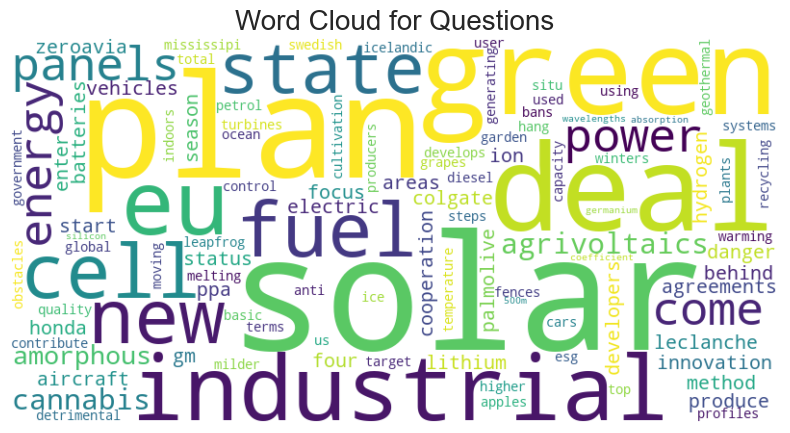

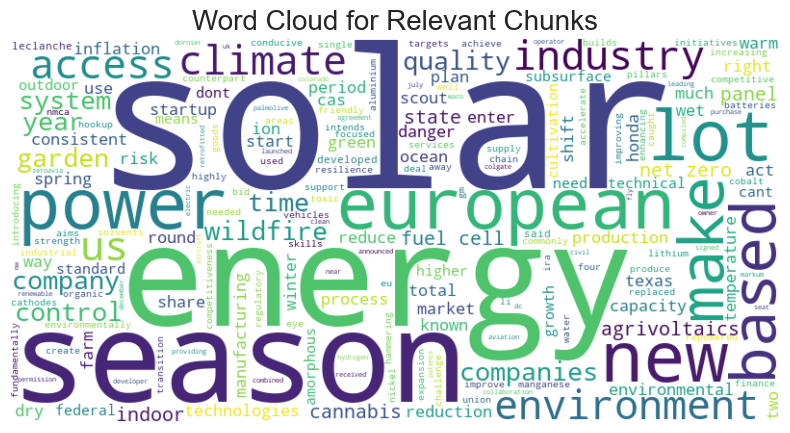

In [93]:
# Generate word cloud for questions
wordcloud_question = WordCloud(width = 800, height = 400, background_color ='white').generate(' '.join(ct_evaluation['question_clean']))
wordcloud_chunk = WordCloud(width = 800, height = 400, background_color ='white').generate(' '.join(ct_evaluation['relevant_chunk_clean']))

# Display the WordCloud image for questions
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_question, interpolation='bilinear')
plt.title('Word Cloud for Questions', fontsize=20)
plt.axis("off")
plt.show()

# Display the WordCloud image for relevant chunks
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_chunk, interpolation='bilinear')
plt.title('Word Cloud for Relevant Chunks', fontsize=20)
plt.axis("off")
plt.show()

#### CT_Media Cleaning

In [187]:
print("First few rows:")
print(ct_media.head())
#rename the unnamed column name, make a plot for date input, 

First few rows:
   Unnamed: 0                                              title        date  \
0        1280  Qatar to Slash Emissions as LNG Expansion Adva...  2021-01-13   
1        1281               India Launches Its First 700 MW PHWR  2021-01-15   
2        1283              New Chapter for US-China Energy Trade  2021-01-20   
3        1284  Japan: Slow Restarts Cast Doubt on 2030 Energy...  2021-01-22   
4        1285     NYC Pension Funds to Divest Fossil Fuel Shares  2021-01-25   

  author                                            content       domain  \
0    NaN  ["Qatar Petroleum ( QP) is targeting aggressiv...  energyintel   
1    NaN  ["• Nuclear Power Corp. of India Ltd. ( NPCIL)...  energyintel   
2    NaN  ["New US President Joe Biden took office this ...  energyintel   
3    NaN  ["The slow pace of Japanese reactor restarts c...  energyintel   
4    NaN  ["Two of New York City's largest pension funds...  energyintel   

                                              

In [194]:
import pandas as pd

def generate_summary(df):
    # Essentials: type, unique values, missing values
    summary = pd.DataFrame({
        'type': df.dtypes,
        'unique_values': df.nunique(),
        'missing_values': df.isnull().sum()
    })
    
    # Quantile statistics for numeric columns only
    numeric_cols = df.select_dtypes(include='number')
    quantiles = numeric_cols.quantile([0, 0.25, 0.5, 0.75, 1]).transpose()
    
    # Add quantile stats to the summary
    summary_stats = pd.concat([summary, quantiles], axis=1)
    
    # Compute range and interquartile range (IQR)
    summary_stats['range'] = summary_stats[1.0] - summary_stats[0.0]
    summary_stats['iqr'] = summary_stats[0.75] - summary_stats[0.25]
    
    return summary_stats

# Apply the summary function to both datasets
ct_media_summary = generate_summary(ct_media)

# Display the summaries
print("\nSummary for ct_media:")
print(ct_media_summary)


Summary for ct_media:
              type  unique_values  missing_values     0.0     0.25      0.5  \
Unnamed: 0   int64           9593               0  1280.0  17156.0  45991.0   
title       object           9569               0     NaN      NaN      NaN   
date        object            967               0     NaN      NaN      NaN   
author      object              7            9562     NaN      NaN      NaN   
content     object           9588               0     NaN      NaN      NaN   
domain      object             19               0     NaN      NaN      NaN   
url         object           9593               0     NaN      NaN      NaN   

               0.75      1.0    range      iqr  
Unnamed: 0  79250.0  81816.0  80536.0  62094.0  
title           NaN      NaN      NaN      NaN  
date            NaN      NaN      NaN      NaN  
author          NaN      NaN      NaN      NaN  
content         NaN      NaN      NaN      NaN  
domain          NaN      NaN      NaN      NaN  
u

In [199]:
# Handle date, look into consistency and earlies and latest date
# Check the earliest and latest dates
print("Earliest date:", ct_media['date'].min())
print("Latest date:", ct_media['date'].max())

# Check the frequency of each date to identify any unusual patterns
date_counts = ct_media['date'].value_counts().sort_index()
print("Date frequencies:\n", date_counts.head())

Earliest date: 2021-01-01 00:00:00
Latest date: 2023-12-05 00:00:00
Date frequencies:
 2021-01-01    3
2021-01-02    1
2021-01-03    2
2021-01-04    5
2021-01-05    8
Name: date, dtype: int64


In [203]:
import pandas as pd

def unique_characters(column):
    return set(''.join(column))

# Load your data (assuming DataFrame is named ct_media)
# ct_media = pd.read_csv('path_to_your_file.csv')

# Inspect unique characters in the title
title_chars = unique_characters(ct_media['title'])
print("Unique characters in 'title':", title_chars)

# Inspect unique characters in the content
content_chars = unique_characters(ct_media['content'])
print("Unique characters in 'content':", content_chars)


Unique characters in 'title': {'ü', 'ç', 'L', ')', 'U', 'í', '9', 'ä', 'u', 'ú', 'C', 'a', 'N', '™', 'P', 'b', '₂', 's', 'l', '⅓', '@', 'y', '&', '%', 'R', '‘', 'Z', '5', '×', '!', '+', 'J', 'H', "'", 'á', 'W', 'q', '°', '1', 'o', 'x', '[', '?', '6', 'g', 'Ø', 'É', ';', 'ö', '=', 'D', '/', ']', 'f', ' ', 'B', 'p', 'm', 'M', 'ë', 'E', 'e', 'k', 'T', '½', '2', '€', '’', 'ø', 'Q', '“', '–', '>', 'I', 'F', 'â', '\u200b', '0', '3', 'w', 'é', '4', 'j', '(', '£', 'i', '…', '-', '.', '®', 'à', '7', '”', '⅙', '#', '`', 'h', ':', 'Ö', 'X', 'v', 'A', 'V', ',', '*', 'n', 'c', 'å', 'K', 'ó', '—', 'O', 'd', 'ē', '$', '~', 'S', 'z', 'Y', 'r', 'G', '8', 't'}
Unique characters in 'content': {'ç', 'ï', '开', '🎉', 'ż', '9', 'ª', 'C', 'வ', 'æ', 'a', 'Ü', 'l', '⋅', 'Ł', 'ū', 'Í', '😳', 'м', '‑', 'ு', 'Ç', '🛢', 'Z', '🎄', 'ê', '×', 'ɑ', 'ù', 'H', 'χ', '}', 'Т', '‰', 'W', 'q', 'О', '🚀', 'р', '👏', '😍', '©', '，', 'x', '[', '6', 'й', '😀', 'Ø', 'с', '·', ']', '회', 'Æ', 'д', '👇', 'M', '"', '毛', 'ы', '℃', 'k', '🇸', '

### Cleaning Title

In [206]:
import unicodedata
import re

def clean_title(text):
    # Normalize unicode characters and convert to lower
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8').lower()
    # Remove special characters
    text = re.sub(r'[^\w\s-]', '', text)
    return text

# Apply the cleaning function to the title column
ct_media['title'] = ct_media['title'].apply(clean_title)

# Display the cleaned titles
print(ct_media['title'].head())

#examine unique characters again
title_chars = unique_characters(ct_media['title'])
print("Unique characters in 'title':", title_chars)

0    qatar to slash emissions as lng expansion adva...
1                 india launches its first 700 mw phwr
2                new chapter for us-china energy trade
3    japan slow restarts cast doubt on 2030 energy ...
4       nyc pension funds to divest fossil fuel shares
Name: title, dtype: object
Unique characters in 'title': {'7', 'q', 'e', 'h', 'k', '9', 'u', '1', 'v', '2', 'o', 'a', 'x', '6', 'n', 'b', 'l', 's', 'g', 'c', 'y', '0', '3', 'd', 'w', '5', '4', 'f', ' ', 'j', 'z', 'r', 'i', 'p', '8', '-', 't', 'm'}


### Cleaning content

In [208]:
def clean_content(text):
    # Normalize unicode characters
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8').lower()
    # Remove HTML tags (if any)
    text = re.sub(r'<[^>]+>', '', text)
    # Remove emojis
    text = re.sub(r'[^\w\s.,-]', '', text)
    return text

# Apply the cleaning function to the content column
ct_media['content'] = ct_media['content'].apply(clean_content)

# Display the cleaned content
print(ct_media['content'].head())

# Inspect unique characters in the content
content_chars = unique_characters(ct_media['content'])
print("Unique characters in 'content':", content_chars)

0    qatar petroleum  qp is targeting aggressive cu...
1     nuclear power corp. of india ltd.  npcil sync...
2    new us president joe biden took office this we...
3    the slow pace of japanese reactor restarts con...
4    two of new york citys largest pension funds sa...
Name: content, dtype: object
Unique characters in 'content': {'7', 'q', 'e', 'h', 'k', '9', 'u', '1', 'v', '2', 'o', 'a', ',', 'x', '6', 'n', 'b', 's', 'l', 'g', 'c', 'y', '0', '3', 'd', 'w', '5', '4', 'f', ' ', 'j', 'z', 'r', 'i', 'p', '8', '-', 't', 'm', '.'}


#### TOKANIZATION


In [210]:
# Example of tokenization using NLTK for whole dataset
import nltk
from nltk.tokenize import word_tokenize

# You might need to download the NLTK tokenizer resources
#nltk.download('punkt')

# Applying tokenization
ct_media['tokenized_content'] = ct_media['content'].apply(word_tokenize)
ct_media['tokenized_title'] = ct_media['title'].apply(word_tokenize)

# Count tokens in both content and title
ct_media['content_token_count'] = ct_media['tokenized_content'].apply(len)
ct_media['title_token_count'] = ct_media['tokenized_title'].apply(len)

# Display the first few entries with token counts
print(ct_media[['tokenized_title', 'title_token_count', 'tokenized_content', 'content_token_count']].head())


                                     tokenized_title  title_token_count  \
0  [qatar, to, slash, emissions, as, lng, expansi...                  8   
1       [india, launches, its, first, 700, mw, phwr]                  7   
2       [new, chapter, for, us-china, energy, trade]                  6   
3  [japan, slow, restarts, cast, doubt, on, 2030,...                  9   
4  [nyc, pension, funds, to, divest, fossil, fuel...                  8   

                                   tokenized_content  content_token_count  
0  [qatar, petroleum, qp, is, targeting, aggressi...                  472  
1  [nuclear, power, corp., of, india, ltd., npcil...                  579  
2  [new, us, president, joe, biden, took, office,...                  767  
3  [the, slow, pace, of, japanese, reactor, resta...                  737  
4  [two, of, new, york, citys, largest, pension, ...                  421  


#### CONTENT

In [212]:
# Frequency distribution of words
from nltk.probability import FreqDist
import nltk
nltk.download('stopwords')

# Flatten the list of tokens and count the frequencies
all_tokens = [token for sublist in ct_media['tokenized_content'] for token in sublist]
freq_dist = FreqDist(all_tokens)

# Print the 10 most common words
print(freq_dist.most_common(10))

# Stopword removal
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# Function to remove stopwords
def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]

# Apply stopword removal
ct_media['filtered_content'] = ct_media['tokenized_content'].apply(remove_stopwords)

# Example of TF-IDF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

# Join tokens back to strings
ct_media['processed_content'] = ct_media['filtered_content'].apply(lambda x: ' '.join(x))

# Initialize a TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the processed content
tfidf_matrix = tfidf_vectorizer.fit_transform(ct_media['processed_content'])

# You can explore tfidf_matrix here or proceed with machine learning modeling


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maaru\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


[(',', 545695), ('the', 411413), ('to', 221504), ('and', 216305), ('of', 203639), ('.', 186691), ('in', 149921), ('a', 132507), ('for', 92227), ('is', 86452)]


In [214]:
#### TITLE

In [213]:
# Flatten the list of tokens from titles and count the frequencies
all_title_tokens = [token for sublist in ct_media['tokenized_title'] for token in sublist]
title_freq_dist = FreqDist(all_title_tokens)

# Print the 10 most common words in titles
print(title_freq_dist.most_common(10))


[('to', 2447), ('in', 2062), ('for', 1904), ('energy', 1792), ('of', 1736), ('solar', 1694), ('the', 1619), ('pv', 1418), ('international', 1238), ('magazine', 1213)]


In [215]:
# Function to remove stopwords from titles
ct_media['filtered_title'] = ct_media['tokenized_title'].apply(remove_stopwords)
print(ct_media['filtered_title'].head())

0    [qatar, slash, emissions, lng, expansion, adva...
1              [india, launches, first, 700, mw, phwr]
2              [new, chapter, us-china, energy, trade]
3    [japan, slow, restarts, cast, doubt, 2030, ene...
4    [nyc, pension, funds, divest, fossil, fuel, sh...
Name: filtered_title, dtype: object


In [216]:
# Join tokens back to strings for titles
ct_media['processed_title'] = ct_media['filtered_title'].apply(lambda x: ' '.join(x))

# Initialize a TF-IDF Vectorizer for titles
title_tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the processed titles
title_tfidf_matrix = title_tfidf_vectorizer.fit_transform(ct_media['processed_title'])


In [217]:
# Join tokens back to strings for titles
ct_media['processed_title'] = ct_media['filtered_title'].apply(lambda x: ' '.join(x))

# Initialize a TF-IDF Vectorizer for titles
title_tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the processed titles
title_tfidf_matrix = title_tfidf_vectorizer.fit_transform(ct_media['processed_title'])


In [218]:
# If you need to explore the shape or type of the matrix
print(title_tfidf_matrix.shape)


(9593, 11886)


#### Handle missing values in author - split at the end to create two separate dataframes


In [200]:
# Creating a DataFrame only with entries that have an author
ct_media_with_authors = ct_media.dropna(subset=['author'])

# Display the new DataFrame
print(ct_media_with_authors.head())

# Creating a DataFrame for entries without an author
ct_media_without_authors = ct_media[ct_media['author'].isnull()]

# Display the DataFrame without authors
print(ct_media_without_authors.head())


      Unnamed: 0                                              title  \
5564       76234  Ecotricity strikes landmark deal to secure geo...   
5565       76235  'Getting to Zero ': New commission to explore ...   
5566       76236  From floating turbines to carbon capture x-ray...   
5567       76237  Electrification of harbour crane moves Port of...   
5568       76238                            No hugging, no learning   

           date               author  \
5564 2021-01-05      Cecilia Keating   
5565 2021-01-05       James S Murray   
5566 2021-01-06  BusinessGreen staff   
5567 2021-01-06      Cecilia Keating   
5568 2021-01-06       James S Murray   

                                                content         domain  \
5564  ["Geothermal energy in the UK took a major ste...  businessgreen   
5565  ['Up to 10 million jobs across the UK are in c...  businessgreen   
5566  ['UK science laboratories and testing faciliti...  businessgreen   
5567  ['The Port of Tyne has made ma

In [202]:
#Inspect the separate dataset

# Check the size of both datasets
print("Entries with authors:", ct_media_with_authors.shape[0])
print("Entries without authors:", ct_media_without_authors[ct_media_without_authors['author'].isnull()].shape[0])

# Inspect the first few entries of the dataset with authors
print("\nFirst few entries with authors:")
print(ct_media_with_authors.head())

# Inspect the first few entries of the dataset without authors
print("\nFirst few entries without authors:")
print(ct_media_without_authors[ct_media_without_authors['author'].isnull()].head())

# Analyze domains to see if there are patterns related to missing authors
print("\nDomain counts for entries with authors:")
print(ct_media_with_authors['domain'].value_counts())

print("\nDomain counts for entries without authors:")
print(ct_media_without_authors[ct_media_without_authors['author'].isnull()]['domain'].value_counts())


Entries with authors: 31
Entries without authors: 9562

First few entries with authors:
      Unnamed: 0                                              title  \
5564       76234  Ecotricity strikes landmark deal to secure geo...   
5565       76235  'Getting to Zero ': New commission to explore ...   
5566       76236  From floating turbines to carbon capture x-ray...   
5567       76237  Electrification of harbour crane moves Port of...   
5568       76238                            No hugging, no learning   

           date               author  \
5564 2021-01-05      Cecilia Keating   
5565 2021-01-05       James S Murray   
5566 2021-01-06  BusinessGreen staff   
5567 2021-01-06      Cecilia Keating   
5568 2021-01-06       James S Murray   

                                                content         domain  \
5564  ["Geothermal energy in the UK took a major ste...  businessgreen   
5565  ['Up to 10 million jobs across the UK are in c...  businessgreen   
5566  ['UK science lab